# Models

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms

import numpy as np
from scipy.stats import norm, truncnorm
from scipy.stats import beta

from tqdm.notebook import tqdm



class NormativePerceptual:
    def __init__(self, *args, **kwargs):
        # print('hey')
        # Leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 12))

        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))

        # Define model type: 'value' or 'logit'
        self.fit_perceptual = kwargs.get('fit_perceptual', 'logit')  # Default to linear

        # Initialize outcome-based prior
        self.prior_mean, self.prior_var = self.initialize_outcome_based_prior()
        # Slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
          # Possible values for the slope
        self.slope_range = kwargs.get('slope_range', np.arange(-10, 10, 0.002))

         # Initialize log-posterior for the slope with prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # Define logit function
        self.logit = lambda x: 1 / (1 + np.exp(x))
        self.kl_perceptual = []

    def initialize_outcome_based_prior(self):
        prior_mean = np.random.uniform(0.1, 0.9, size=len(self.x))  # Uniform prior
        # prior_variance = np.ones(len(self.x)) * 0.3  # Initial variance
        prior_variance = np.random.uniform(0.1, .9, size=len(self.x))  # Initial variance
        return prior_mean, prior_variance

    def perceptual_update(self, choice, outcome):
        """Update the log-posterior of the slope based on observed data."""
        
        if self.fit_perceptual == 'value':
           # get the index using the choice and self.x
            chosen_shield_index = np.where(self.x == choice)[0][0] 
            # get real p
            real_p = (1/(1+np.exp(-2 * choice))).round(2)

            likelihood_var = real_p * (1 - real_p)  # Variance of the likelihood

            # Store old values for KL before updating
            mu_0 = self.prior_mean[chosen_shield_index]
            sigma_0 = np.sqrt(self.prior_var[chosen_shield_index])

            # bayesian update for gaussian likelihoods
            posterior_var = 1 / (1 / self.prior_var[chosen_shield_index] + 1 / likelihood_var)
            posterior_mean = posterior_var * (
                self.prior_mean[chosen_shield_index] / self.prior_var[chosen_shield_index] + 
                outcome / likelihood_var
            )
        
            # Update the specific shield's posterior mean and variance
            self.prior_mean[chosen_shield_index] = posterior_mean
            self.prior_var[chosen_shield_index] = posterior_var

            # After update
            mu_1 = posterior_mean
            sigma_1 = np.sqrt(posterior_var)

            self.kl_perceptual.append(
                np.log(sigma_0 / sigma_1) + (posterior_var + (mu_1 - mu_0) ** 2)
                  / (2 * self.prior_var[chosen_shield_index]) - 0.5
            )

        if self.fit_perceptual == 'logit':
            v = self.slope_range * choice
            v = v - v * 2 * outcome  # Switch to negative if forcefield destroyed
     
            # Binary outcome likelihood
            ll = np.log(self.logit(v))

            # Update log posterior
            self.lp_slope += ll
            
        self._apply_leak_perceptual()

    def predictff(self, ff1=None, ff2=None):
        """Predict outcomes (linear or logit) for given forcefields."""
        if ff1 is None and ff2 is None:
            # Predict for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # Predict for 2 displayed forcefields
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])

        if self.fit_perceptual == 'logit':
            return self.logit(-self.get_slope() * self.x[to_select])
        elif self.fit_perceptual == 'value':
            # Shield value estimates for the selected forcefields (in code range [-1, 1])
            shield_values = self.prior_mean[to_select]  # corresponding shield mean estimates
            return shield_values
        
    def get_shield_var(self, ff1, ff2):
        x = np.arange(len(self.x))
        to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])
        return self.prior_var[to_select]

    def get_slope(self):
        """Compute the current slope as the weighted mean of the slope range."""
        w = np.exp(self.lp_slope - np.max(self.lp_slope))
        slope = np.sum(w * self.slope_range) / np.sum(w)
        return slope

    def _apply_leak_perceptual(self):
        """Apply a leak to the log-posterior of the slope."""
        self.lp_slope *= 1 - self.leak
        self.prior_mean *= 1 - self.leak



class NormativeValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.delta_prior = kwargs.get('delta_prior', .2)
        self.std_prior = kwargs.get('std_prior', .02)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)
        self.states = kwargs.get('states', np.arange(self.nstate))

        # possible values for the difference between two options
        self.delta_range = kwargs.get('delta_range', np.arange(-1, 1, 0.002))

        self.fit_value = kwargs.get('fit_value', 'relative')

        # initialize logposterior for the slope to prior
        # self.lp_delta = [
            # np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
            # for _ in range(self.nstate)
        # ]
        self.lp_delta = {s: np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
                         for s in self.states}
        # self.lp_delta = {}
        # print(self.lp_delta)
        self.prior_means, self.prior_vars = self.initialize_absolute_prior()  
        self.kl_value = []


    def initialize_absolute_prior(self):
        all_ = np.array(self.states.tolist()).flatten()
        prior_mean = {m: np.random.uniform(0.1, 0.9)  for m in all_}
        prior_variance = {m: np.random.uniform(0.1, .9) for m in all_} # Initial variance
        return prior_mean, prior_variance

    def value_update(self, s, a, r):
        
        # self._add_state(s)

        if self.fit_value == 'relative':
            v = 1-self.delta_range if a else 1+self.delta_range
            # compute log likelihood
            ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
            # update log posterior

            self.lp_delta[s] += ll
            self._apply_leak_value(s)

        if self.fit_value == 'absolute':
            # normalize the outcome by prior mean (priors are uniforms
            # so we assume the agent expect average spaceship to be around .5 at first)
            #outcome = r/np.mean(list(self.prior_means.values()))
            outcome = r

            m = s[a] # chosen spaceship index
            # mv = m/1000       
            likelihood_var = .1

                        # Store old values for KL before updating
            mu_0 = self.prior_means[m]
            sigma_0 = np.sqrt(self.prior_vars[m])

            # bayesian update for gaussian likelihoods
            posterior_var = 1 / (1 / self.prior_vars[m] + 1 / likelihood_var)
            posterior_mean = posterior_var * (
                self.prior_means[m] / self.prior_vars[m] + 
                outcome / likelihood_var
            )
        
            # Update the specific shield's posterior mean and variance
            self.prior_means[m] = posterior_mean
            self.prior_vars[m] = posterior_var
            # self._apply_leak_value(s, a)

            # After update
            mu_1 = posterior_mean
            sigma_1 = np.sqrt(posterior_var)

            self.kl_value.append(
                np.log(sigma_0 / sigma_1) + (posterior_var + (mu_1 - mu_0) ** 2)
                  / (2 * self.prior_vars[m]) - 0.5
            )

    def get_means(self, s):
        return self.prior_means[s[0]], self.prior_means[s[1]]
    
    def get_spaceship_var(self, s):
        return np.array([self.prior_vars[s[0]], self.prior_vars[s[1]]])

    def get_delta(self, s):
        # self._add_state(s)
        w = np.exp(self.lp_delta[s]-np.max(self.lp_delta[s]))
        delta = np.sum(w*self.delta_range)/np.sum(w)
        return delta

    def _apply_leak_value(self, s, a=None):
        # self._add_state(s)
        self.lp_delta[s] *= 1-self.leak
        self.prior_means[s[0]] *= 1-self.leak
        self.prior_means[s[1]] *= 1-self.leak

    # def _add_state(self, s):
    #     # if self.lp_delta.get(s) is None:
    #     self.lp_delta[s] = np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
    #     self.prior_means[s[0]] = np.random.uniform(.1, .9)
    #     self.prior_vars[s[0]] = np.random.uniform(.1, .9)
    #     self.prior_means[s[1]] = np.random.uniform(.1, .9)
    #     self.prior_vars[s[1]] = np.random.uniform(.1, .9)


class Normative(NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        NormativeValue.__init__(self, *args, **kwargs)
        NormativePerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        # default is EV decision
        p = self.predictff(ff1, ff2)
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p)
        choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
        return choice

    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # delta (diff between two options) (utf8 character symbol as key)
            '$\delta$': self.get_delta(s) if s is not None
            else [self.get_delta(s) for s in self.states],
        }


class NormativeEV(Normative,
                  NormativeValue, NormativePerceptual):
    def ll_of_choice(self, ff1, ff2, s, a):
        p1 = self.predictff(ff1, ff2)
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p1)
        p1 = 1/(1+np.exp(-self.temp*(ev1-ev2)))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8
        return p


class NormativeLogRatio(Normative,
                        NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        p = np.log(self.predictff(ff1, ff2))
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        choice = int(np.random.random() > 1/(1+np.exp(-x)))
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        p = np.log(self.predictff(ff1, ff2)) 
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        p1 = 1/(1+np.exp(-x))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8

        return p
    

class NormativeIndependent(Normative,NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)
        self.var = kwargs.get('var', 0)


    def make_choice(self, s, ff1, ff2):
        def zscore(x, y):
        # centered around 0.5
            return np.clip( .5 + (x - np.mean(y)) / (4*np.std(y)), a_min=.001, a_max=1)

        def minmax(x, y):
            return (x - np.min(y)) / (np.max(y) - np.min(y)) + 1e-8


        p = self.predictff(ff1, ff2)
        p = np.array(p) + 1e-8  # Avoid dividing by 0 or other shits
        
        norm_p = zscore(p, y=self.prior_mean)
          # Predict shield probabilities
        # Get spaceship values
        ev = self.get_means(s)
        norm_ev = zscore(ev, y=np.array(list(self.prior_means.values())))
     
        # y = np.array([.21, .21, .21, .21])
        var_spaceship = self.get_spaceship_var(s)
        var_spaceship = zscore(var_spaceship, y=np.array(list(self.prior_vars.values())))

        # var_spaceship = var_spaceship/np.max(var_spaceship)
        # y = np.array([0.11, 0.15, 0.2 , 0.24, 0.25, 0.24, 0.2 , 0.15, 0.11])
        var_shield = self.get_shield_var(ff1, ff2)
        var_shield = zscore(var_shield, y=self.prior_var)
        # var_shield = var_shield/np.max(var_shield)

        # TODO check by normalization by max (should it be on all cues or only on the ones used?)0
        # if var is true then we use the variance of the spaceship values and shield probabilities
        wv1, wv2 = np.array([1, 1]) * (1 - self.var) + (1/var_spaceship) * self.var
        wp1, wp2 = np.array([1, 1]) * (1 - self.var) + (1/var_shield) * self.var
        
        v1 = self.rl_temp * (norm_ev[0] * 1) + self.perceptual_temp * (norm_p[0] * wp1)
        v2 = self.rl_temp * (norm_ev[1] * 1) + self.perceptual_temp * (norm_p[1] * wp2)
        
        # Compute choice probability
        x = v1 - v2
        choice = int(np.random.random() > 1 / (1 + np.exp(-x)))
        
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        def zscore(x, y):
            # centered around 0.5
            return np.clip( .5 + (x - np.mean(y)) / (4*np.std(y)), a_min=.001, a_max=1)

        def minmax(x, y):

            return (x - np.min(y)) / (np.max(y) - np.min(y)) + 1e-8


        p = self.predictff(ff1, ff2)
        p = np.array(p) + 1e-8  # Avoid dividing by 0 or other shits
        
        norm_p = zscore(p, y=self.prior_mean)
          # Predict shield probabilities
        # Get spaceship values
        ev = self.get_means(s)
        norm_ev = zscore(ev, y=np.array(list(self.prior_means.values())))
     
        # y = np.array([.21, .21, .21, .21])
        var_spaceship = self.get_spaceship_var(s)
        var_spaceship = zscore(var_spaceship, y=np.array(list(self.prior_vars.values())))

        # var_spaceship = var_spaceship/np.max(var_spaceship)
        # y = np.array([0.11, 0.15, 0.2 , 0.24, 0.25, 0.24, 0.2 , 0.15, 0.11])
        var_shield = self.get_shield_var(ff1, ff2)
        var_shield = zscore(var_shield, y=self.prior_var)
        # var_shield = var_shield/np.max(var_shield)

        # TODO check by normalization by max (should it be on all cues or only on the ones used?)0
        # if var is true then we use the variance of the spaceship values and shield probabilities
        wv1, wv2 = np.array([1, 1]) * (1 - self.var) + (1/var_spaceship) * self.var
        wp1, wp2 = np.array([1, 1]) * (1 - self.var) + (1/var_shield) * self.var
        
        v1 = self.rl_temp * (norm_ev[0] * 1) + self.perceptual_temp * (norm_p[0] * wp1)
        v2 = self.rl_temp * (norm_ev[1] * 1) + self.perceptual_temp * (norm_p[1] * wp2)
        
        # Compute choice probability
        x = v1 - v2

        p1 = 1 / (1 + np.exp(-x))
        pp = [p1, 1 - p1]
        
        pp[a] = max(pp[a], 1e-8)  # Avoid dividing by 0 or other shits
        return pp


class Arbitration(Normative,NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)
        self.var = kwargs.get('var', 0)
        self.bias = kwargs.get('bias', 0)


    def make_choice(self, s, ff1, ff2):
        def zscore(x, y):
            # centered around 0.5
            return np.clip( .5 + (x - np.mean(y)) / (4*np.std(y)), a_min=.001, a_max=1)

        def minmax(x, y):
            return (x - np.min(y)) / (np.max(y) - np.min(y)) + 1e-8


        p = self.predictff(ff1, ff2)
        p = np.array(p) + 1e-8  # Avoid dividing by 0 or other shits
        
        norm_p = zscore(p, y=self.prior_mean)
          # Predict shield probabilities
        # Get spaceship values
        ev = self.get_means(s)
        norm_ev = zscore(ev, y=np.array(list(self.prior_means.values())))

        kl_p = minmax(self.kl_perceptual[-1], y=self.kl_perceptual)
        kl_v = minmax(self.kl_value[-1], y=self.kl_value)

        w_pv = 1 / (1 + np.exp(-(kl_p - kl_v + self.bias)))
    
        v1, v2 = w_pv * norm_p + (1 - w_pv) * norm_ev

        x = v1 - v2
        choice = int(np.random.random() > 1 / (1 + np.exp(-x)))
        
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        def zscore(x, y):
            # centered around 0.5
            return np.clip( .5 + (x - np.mean(y)) / (4*np.std(y)), a_min=.001, a_max=1)

        # def minmax(x, y):
        #     return (x - np.min(y)) / (np.max(y) - np.min(y)) + 1e-6
        
        def minmax(x, y):
            range_y = np.max(y) - np.min(y)
            if np.isclose(range_y, 0):
                return np.zeros_like(x)  # or 0.5, or x depending on your use case
            return (x - np.min(y)) / (range_y + 1e-6)

        p = self.predictff(ff1, ff2)
        p = np.array(p) + 1e-8  # Avoid dividing by 0 or other shits
        
        norm_p = zscore(p, y=self.prior_mean)
          # Predict shield probabilities
        # Get spaceship values
        ev = self.get_means(s)
        norm_ev = zscore(ev, y=np.array(list(self.prior_means.values())))

        if (len(self.kl_perceptual) == 0) or (len(self.kl_value) == 0):
            kl_p = 1
            kl_v = 1
        else:
            kl_p = minmax(self.kl_perceptual[-1], y=self.kl_perceptual)
            kl_v = minmax(self.kl_value[-1], y=self.kl_value)

        w_pv = 1 / (1 + np.exp(np.clip(-(kl_p - kl_v + self.bias), -1000, 1000)))
    
        v1, v2 = w_pv * norm_p + (1 - w_pv) * norm_ev
    
        x = v1 - v2
        p1 = 1 / (1 + np.exp(-x))
        pp = [p1, 1 - p1]
        
        pp[a] = max(pp[a], 1e-8)  # Avoid dividing by 0 or other shits


        return pp
       


class RandomModel:
    def __init__(self, *args, **kwargs):
        self.params = kwargs.get('params', [])

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(a, r):
        pass

    @staticmethod
    def learn_value(s, a, r):
        pass

    def get_params(self, s=None):
        return self.params


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p


def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc).pdf(x)


def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    x = truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    return x[0] if len(x) == 1 else x


# load data

In [56]:

import seaborn as sns
# import sys
# sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('../data/raw/fullpilot13_2.csv')
df2 = pd.read_csv('../data/raw/fullpilot1466.csv')


df2 = df2[df2.expName.isin(['FullPilot14'])]
df = df[df.expName.isin(['FullPilot13', 'FullPilot12'])]

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
df2 = df2[df2.prolificID.str.len() > 10]
# show prolificIDs 

df = pd.concat([df, df2])
df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14'])]

df = df[df.session.isin([0, 1, 2, 3])]

# Adjust `t` to be cumulative across sessions
# Compute the number of trials in each session
session_counts = df.groupby('session')['t'].max() + 1

# Compute the cumulative starting points for each session
cumulative_starts = session_counts.cumsum().shift(fill_value=0)

# Map each session to its starting point and adjust `t`
df['t'] = df['t'] + df['session'].map(cumulative_starts)

df = df[df.choice.isin([1, 2])]
# df = df[df.pair.isin([0,1])]
df.loc[df.expName=='FullPilot14', 'destroyed'] = 1

df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['correct'] = (df.ev1 > df.ev2) & (df.choice == 1) | (df.ev2 > df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)
df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)
df['outcome'] /= 1000
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
# df['trial'] = ((df.t.max()+1) * (df.session-2)) + df.t
df['trial'] = df.t
df['s'] = list(zip(df.m1, df.m2))

print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

# df['pair'] = df.pair.apply(lambda x: 0 if x < 0 else x)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)

print(pp)
    # break



Number of participants: 190
[0.12 0.18 0.27 0.38 0.5  0.62 0.73 0.82 0.88]


# grouping


In [58]:
session = 3
df_ = df[(df.session==session)].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

import scipy.stats as stats

df_['delta'] = df_.opti_ff - df_.opti_ss

df_['opti_ff'] = df_.opti_ff.astype(float)
df_['opti_ss'] = df_.opti_ss.astype(float)
df_['delta'] = df_.delta.astype(float)
df['opti_ff'] = df['opti_ff'].astype(float)
df['opti_ss'] = df['opti_ss'].astype(float)
         
df2 = df[(df.session==session)]

def get_group2(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    ttest = stats.ttest_rel(opti_ff, opti_ss)
    p = ttest.pvalue
    t = ttest.statistic
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p > 0.05:
        if p_ss and p_ff:
            return 'balanced'
        if p_ss:
            return 'value'
        if p_ff:
            return 'perceptual'
        return 'random'
    
    if t > 0 and p_ff:
        return 'perceptual'
    if t < 0  and p_ss:
        return 'value'

    return 'random'

def get_group(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p_ss and p_ff:
        return 'combined'
        
    
    if p_ff:
        return 'perceptual'
    if p_ss:
        return 'value'

    return 'random'
    # raise ValueError('unexpected value')

df_['group'] = df_.apply(get_group, axis=1)

df['group'] = df['prolificID'].map(df_.set_index('prolificID')['group'])

# df = df[df.group != 'random']
print(len(df.prolificID.unique()))

190


In [4]:
import pandas as pd
import numpy as np


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
map_ff_values[1] = 1
df['agent'] = df.prolificID

df['s'] = list(zip(df.m1, df.m2))
df['a'] = df.choice - 1
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
# if (df.p1.unique()[0]==1):
    # df['ff1'] = .25
    # df['ff2'] = .25
df['destroy'] = df.destroyed



# FIT


In [5]:
import itertools
from scipy.special import logsumexp

def fit(x0, *args):
    # print('Running fit...')
    exp, model, session, ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    try:
        _ = len(x0)
    except:
        x0 = [x0]

    if model == 'single':
        temp = x0[0]
        # leak = x0[2]
        leak = 0
        fit_perceptual = 'single'
        fit_value = 'single'
        m = NormativeEV(states=s, nstate=len(np.unique(s)), x=list(ff_values), temp=temp, leak=leak)

    # if model == 'random':
        # m = RandomModel(params=x0)
    if 'perceptual' in model:
        perceptual_temp = x0[0]
        rl_temp = 0
        leak = 0
        fit_perceptual = 'value'
        fit_value = 'absolute'
        var = int('var' in model)
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), fit_perceptual=fit_perceptual, fit_value=fit_value, var=var)
    
    if 'value' in model:
        perceptual_temp = 0
        rl_temp = x0[0]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        var = int('var' in model)
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), fit_perceptual=fit_perceptual, fit_value=fit_value, var=var)
        

    if model == 'log-ratio':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_perceptual = 'logit'
        fit_value = 'relative'
        # leak = x0[2]
        m = NormativeLogRatio(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), 
                                fit_perceptual=fit_perceptual, fit_value=fit_value, slope_prior=.5)

    if model == 'absolute':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        # leak = x0[2]
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                  perceptual_temp=perceptual_temp, rl_temp=rl_temp, leak=leak, x=list(ff_values),
                                  fit_value=fit_value, fit_perceptual=fit_perceptual, var=0)
    
    if model == 'absolute-var':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        # leak = x0[2]
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                  perceptual_temp=perceptual_temp, rl_temp=rl_temp, leak=leak, x=list(ff_values),
                                  fit_value=fit_value, fit_perceptual=fit_perceptual, var=1)
    if model == 'arbitration':
        perceptual_temp = 0
        rl_temp = 0
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        bias = x0[0]
        m = Arbitration(states=s, nstate=len(np.unique(s)),
                                  perceptual_temp=perceptual_temp, rl_temp=rl_temp, leak=leak, x=list(ff_values),
                                  fit_value=fit_value, fit_perceptual=fit_perceptual, var=0, bias=bias)
    
    if model != 'random':
        ll = 0

        for t in range(ntrials):
            
            # if a[t] not in (0, 1):
                # continue
            
            if session[t] in (1, 3) and ('value' not in model):
                ff_chosen = [ff1[t], ff2[t]][a[t]]
                if exp == 'FullPilot14':
                    m.learn_perceptual(ff_chosen, r[t])
                else:
                    m.learn_perceptual(ff_chosen, destroy[t])

            if session[t] in (0, 2, 3) and ('perceptual' not in model):
                if destroy[t] or exp == 'FullPilot14':
                    m.learn_value(s[t], a[t], r[t])
            
            # print('Session:', session[t], 'Trial:', t, 'ff1:', ff1[t], 'ff2:', ff2[t], 's:', s[t], 'a:', a[t], 'r:', r[t], 'destroy:', destroy[t])
            p_of_choices = m.ll_of_choice(ff1[t], ff2[t], s[t], a[t])
            ll += np.log(np.exp(p_of_choices - logsumexp(p_of_choices)))[a[t]]          
                
    else:
        ll = 0
        for t in range(ntrials):
            ll += np.log(np.exp([.5, .5] - logsumexp([.5, .5])))[0]

    return -ll, m.get_params()

def fit_pwf(x0, *args):
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    logistic = lambda ff, x: 1/(1+np.exp(ff*-x))
    ll = 0

    for t in range(ntrials):
        ff = np.array([ff1[t], ff2[t]])

        # ll += np.log(logistic(ff_chosen, x0[0]))
        x = logistic(ff, x0[0]) * r[t]
        
        # p1 = 1/(1+np.exp(x[1]-x[0]))
        # p2 = 1-p1
        # ll += np.log([p1, p2][a[t]])
        # end loop

        ll += np.log(np.exp(x - logsumexp(x)))[a[t]]

    return (-ll, 0)


def minimize(f, space, args):
    array = np.zeros(len(space))
    params = []
    count = 0
    for x in space:
        array[count], param = f(x, *args)
        params.append(param)
        count += 1
    argmin = np.argmin(array)
    return (space[argmin], array[argmin],params[argmin], array)
        


    

In [53]:
from joblib import Parallel, delayed
import itertools
from pybads import BADS
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

# Assuming df is predefined
exp = ['FullPilot12', 'FullPilot13', 'FullPilot14']
agents = df[(df.expName.isin(exp))].agent.unique()
models = ['arbitration', 'absolute']
parallel = True 

# Function to optimize for one agent and model
def optimize_agent_model(agent, model, agent_data):
    # print('Running optimization for', agent, model)
    df2 = agent_data
    # drop rows where session==3 and pair is not in [0,1]
    
    # Condition to drop rows
    condition = (df2['session'] == 3) & (~df2['pair'].isin([0, 1]))

    # Drop rows meeting the condition, keeping other rows intact
    df2 = df2.loc[~condition]
    df2 = df2[df2.session==3]

    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    session = df2.session.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]
    exp = df2.expName.values[0]

    def target(x):
        return fit(x, *(exp, model, session, ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    if any(s in model for s in ['single', 'value', 'perceptual', 'arbitration']):
        lower_bounds = np.array([-1e3])
        upper_bounds = np.array([1e3])
        x0 = np.array([1])

    if  any(s in model for s in ['absolute', 'log-ratio', 'absolute-var']):
        lower_bounds = np.array([0, 0])
        upper_bounds = np.array([1e3, 1e3])
        x0 = np.array([1, 1])
    

    # lower_bounds = np.array([0, 0, 0])
    # upper_bounds = np.array([100, 100, 1])
    # x0 = np.array([1, 1, 0.5])

    bads = BADS(
        target,
        x0=x0,
        lower_bounds=lower_bounds,
        upper_bounds=upper_bounds,
        options={'display': 'off'}
    )

    optimize_result = bads.optimize()
    return (agent, model), {'agent': agent, 'model': model, 'x': optimize_result.x, 'll': optimize_result.fval}

# Prepare list of all agent-model pairs
tasks = list(itertools.product(agents, models))
# pbar = tqdm(total=len(agents)*len(models))


if parallel:
    # Parallel execution with notebook-friendly progress bar
    results = []
    for result in Parallel(n_jobs=-2, # Use all available cores except 1 to keep the system responsive
                            backend='loky' 
    )(delayed(optimize_agent_model)(agent, model, df[df.agent == agent].sort_values('t')) for agent, model in tqdm(tasks)):
        results.append(result)

else:

    # non parallel version
    results = []
    for agent, model in tasks:
        results.append(optimize_agent_model(agent, model, df[df.agent == agent].sort_values('t')))
        pbar.update()


# Gather results
xopt = dict(results)

# save the dict xopt
import pickle
with open('xopt_arbitration_no_training.pkl', 'wb') as f:
    pickle.dump(xopt, f)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
xopt = pickle.load(open('xopt_arbitration.pkl', 'rb'))

In [ ]:
xopt 

{('610a1655e385fd7341e12778',
  'arbitration'): {'agent': '610a1655e385fd7341e12778', 'model': 'arbitration', 'x': array([1.03376806e-07]), 'll': 195.34188967305673},
 ('610a1655e385fd7341e12778',
  'absolute'): {'agent': '610a1655e385fd7341e12778', 'model': 'absolute', 'x': array([9.99999999e+02, 9.74610873e-01]), 'll': 186.3863650064526},
 ('66f6c4195f17d26ce8c8018d',
  'arbitration'): {'agent': '66f6c4195f17d26ce8c8018d', 'model': 'arbitration', 'x': array([1.03376806e-07]), 'll': 192.59259026159128},
 ('66f6c4195f17d26ce8c8018d',
  'absolute'): {'agent': '66f6c4195f17d26ce8c8018d', 'model': 'absolute', 'x': array([722.25174451,  90.19579315]), 'll': 157.7832094238821},
 ('636590165e6fcc3e84ee2b6d',
  'arbitration'): {'agent': '636590165e6fcc3e84ee2b6d', 'model': 'arbitration', 'x': array([443.49945351]), 'll': 195.87953059199904},
 ('636590165e6fcc3e84ee2b6d',
  'absolute'): {'agent': '636590165e6fcc3e84ee2b6d', 'model': 'absolute', 'x': array([5.21540642e-06, 5.21540642e-06]), 'll

In [ ]:
# save the dict xopt
import pickle
with open('xopt_absolute_var_4.pkl', 'wb') as f:
    pickle.dump(xopt, f)

In [84]:
import pickle 
xopt = pickle.load(open('xopt_absolute_var_fixed_wv.pkl', 'rb'))

In [85]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
d = []
for (agent, model), value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    # print(agent, model, value['x'], value['ll'])

    if any(s in model for s in ['single', 'value', 'perceptual']):
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            'model': model,
            'value': value['x'][0],
            'll': value['ll'],
            'param': '$\\beta$',
            'param2': 'beta'
        })
        
    elif any(s in model for s in ['arbitration']):
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            'model': model,
            'value': value['x'][0],
            'll': value['ll'],
            'param': '$\\\delta$',
            'param2': 'delta'
        })
    else:   
       
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            'model': model,
            'value': value['x'][0],
            'll': value['ll'],
            'param': '$\\beta_P$',
            'param2': 'beta_ff'
        })
        
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            # 'model': 'NormativeEV',
            'model': model,
            'value': value['x'][1],
            'll': value['ll'],
            'param': '$\\beta_V$',
            'param2': 'beta_ss'
        })

        # dd.append({
        #         'agent': agent,
        #         'expName': df[df.prolificID==agent].expName.values[0],
        # 'group': df[df.prolificID==agent].group.values[0],
        # 'model': model,
        # 'value': value['x'][2],
        # 'll': value['ll'],
        # 'param': '$\\lambda$',
        #     'param2': 'leak'
        # })

dd = pd.DataFrame(d)
# dd.to_csv('../data/processed/fit_params_fullpilot13_2_models.csv', index=False)

TtestResult(statistic=9.278116677494562, pvalue=1.422542400056317e-09, df=25.0)

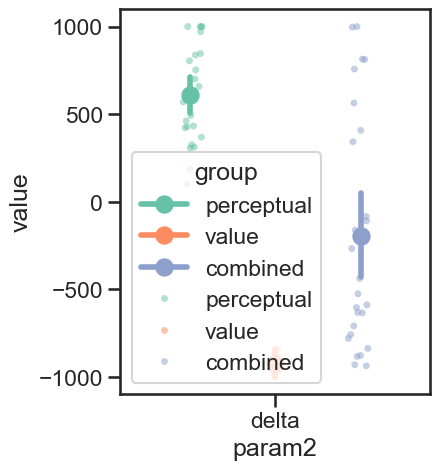

In [44]:
# compare delta for group perceptual and value
import seaborn as sns
import matplotlib.pyplot as plt

# compare delta for group perceptual and value in model='arbitration'
# with ttest
import scipy.stats as stats

# ttest for perceptual and value
ddf = dd[dd.group.isin(['perceptual', 'value', 'combined'])]
# replace every perceptual by value and value by perceptual in group column
# ddf['group'] = ddf['group'].replace({'perceptual': 'value', 'value': 'perceptual'})
ddf = ddf[ddf.model.isin(['arbitration']) & (ddf.expName.isin(['FullPilot14']))]
sns.pointplot(data=ddf, x='param2', y='value', hue='group', hue_order=['perceptual', 'value', 'combined'], dodge=.55)
sns.stripplot(data=ddf, x='param2', y='value', hue='group', hue_order=['perceptual', 'value', 'combined'], dodge=True, alpha=0.5)
stats.ttest_ind(ddf[ddf.group=='perceptual'].value, ddf[ddf.group=='value'].value)



In [ ]:
dd.to_csv('../data/processed/fit_params_full_latest_fixed_wv.csv', index=False)

In [ ]:
dd = pd.read_csv('../data/processed/fit_params_full_latest_fixed_wv_inf.csv')

dd[dd.param2=='beta_ss'].value.mean()

340758.74338573305

In [63]:
dd.groupby(['model']).size()

model
absolute      380
map            61
perceptual    190
value         190
dtype: int64

In [2]:
import pandas as pd
dd = pd.read_csv('../data/processed/fit_params.csv') 

In [3]:
dd2 = pd.read_csv('../data/processed/omega_model_FullPilot12_prior_beta_50_2.csv')

In [4]:
dd = pd.concat([dd, dd2])

In [84]:
dd.model.unique()

array(['absolute', 'value', 'perceptual', 'map'], dtype=object)

In [9]:
import numpy as np
n_param = {
    'single': 1,
    'value': 1,
    'perceptual': 1,
    'value-var': 1,
    'perceptual-var': 1,
    'absolute': 2,
    'log-ratio': 2,
    'absolute-var': 2,
    'arbitration': 1,
    'random': 0,
    'map': 2,
}


def compute_bic(ddf):
    # size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size().values[0]
    return 2 * ddf.ll + ddf.n_param * np.log(314)

In [10]:
dd['n_param'] = dd.model.map(n_param)
dd['bic'] = compute_bic(dd)

In [11]:
dd.loc[dd.model=='map', 'expName'] = 'FullPilot12'

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

absolute vs. map: t-test paired samples, P_val:6.552e-52 t=5.261e+01


(<Axes: xlabel='model', ylabel='bic'>,
 [<statannotations.Annotation.Annotation at 0x1eee5e27fd0>])

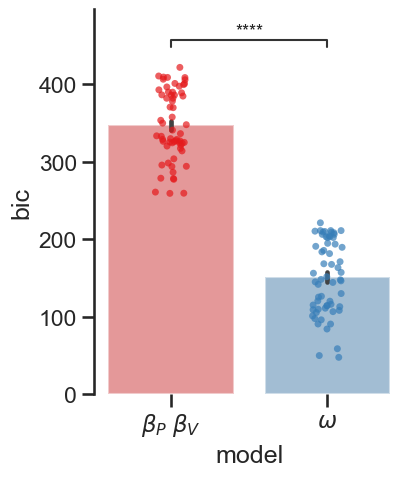

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.figsize': (4, 5)})
sns.set_style('ticks')
sns.set_context('talk')
from statannotations.Annotator import Annotator

data = dd[dd.expName=='FullPilot12'].groupby(['agent', 'model'], as_index=False).mean(numeric_only=True)
data = data[data.model.isin(['map', 'absolute'])]
ax = sns.barplot(data=data, x='model', y='bic', hue='model', palette='Set1', errorbar='se', alpha=.5, zorder=0)
sns.stripplot(data=data, x='model', y='bic', hue='model', palette='Set1', alpha=0.7)
sns.despine(bottom=True)
plt.xticks([0,1],['$\\beta_P$ $\\beta_V$', '$\\omega$'])

pairs = [('absolute', 'map')]
hues = ['absolute', 'map']
annotator = Annotator(ax, pairs, data=data, x='model', y='bic', order=['absolute', 'map'], hue='model', hue_order=hues, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
annotator.apply_and_annotate()



In [65]:
dd.loc[dd.model=='map', 'expName'] = 'FullPilot12'

In [ ]:
# compare bics for expName == 'FullPilot12'



In [ ]:
dd.to_csv('../data/processed/fit_params_absolute_var_7_session_3_only.csv', index=False)

## P(MODEL)

## model x group

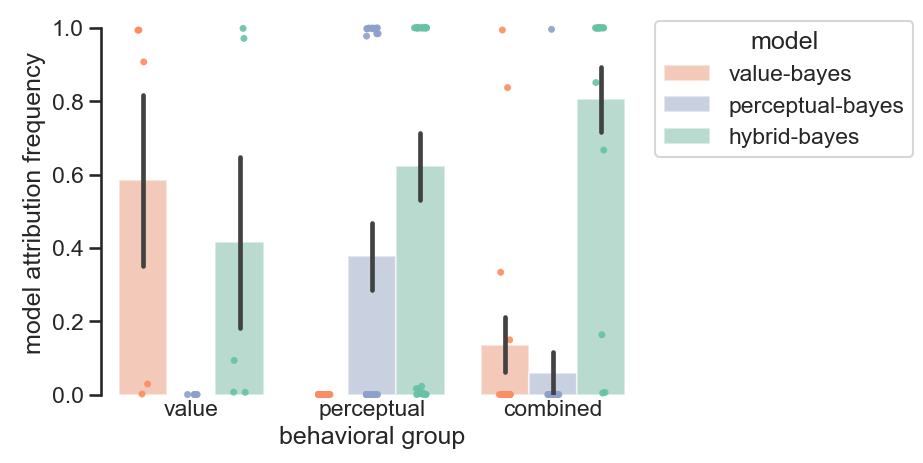

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    # df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic

by_pid = dd[dd.expName=='FullPilot12'].groupby(['agent', 'model','group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

x = ['value', 'perceptual', 'combined']
hues = ['value', 'perceptual-var', 'absolute-var']
L = create_array(x=x,
                  hue=hues, df=by_pid)

for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.group==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (7, 5), 'figure.dpi': 100})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined']
palette = ['C1', 'C2', 'C0']
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,
            hue_order=hues, palette=palette)


x_values = by_pid['group'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

# annotator = Annotator(ax, pairs, data=by_pid, x='group', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
# annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
# annotator.apply_and_annotate()

sns.stripplot(data=by_pid, x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,
            hue_order=hues, palette=palette, clip_on=False)
# plt.ylim(200, 600)
plt.ylabel('model attribution frequency')
plt.xlabel('behavioral group')
# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:3], labels=['value-bayes', 'perceptual-bayes', 'hybrid-bayes'], title='model', loc='upper left')

sns.despine(bottom=True, trim=True)
# xtick length =0 
plt.tick_params(axis='x', length=0)


## Exp x group x model

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute vs. combined_absolute-var: t-test paired samples, P_val:2.804e-10 t=-1.375e+01
random_absolute vs. random_absolute-var: t-test paired samples, P_val:4.420e-01 t=-8.043e-01
random_value vs. random_perceptual: t-test paired samples, P_val:9.362e-02 t=1.875e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:1.363e-14 t=-1.456e+01
combined_value vs. combined_perceptual: t-test paired samples, P_val:2.230e-01 t=1.268e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:3.732e-01 t=-1.002e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:1.752e-01 t=-1.645e+00
value_value vs. value_perceptual: t-test paired samples, P_val:6.728e-02 t=2.493e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_va

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute vs. combined_absolute-var: t-test paired samples, P_val:4.662e-05 t=-5.971e+00
random_absolute vs. random_absolute-var: t-test paired samples, P_val:1.554e-01 t=-1.508e+00
random_value vs. random_perceptual: t-test paired samples, P_val:1.820e-02 t=2.700e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:3.703e-24 t=-5.003e+01
combined_value vs. combined_perceptual: t-test paired samples, P_val:3.204e-02 t=2.401e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:2.336e-01 t=-1.254e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:3.386e-02 t=-2.394e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.852e-04 t=5.310e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_va

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


random_absolute vs. random_absolute-var: t-test paired samples, P_val:3.119e-02 t=-2.505e+00
random_value vs. random_perceptual: t-test paired samples, P_val:5.562e-01 t=6.088e-01
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:1.550e-32 t=-1.070e+02
combined_value vs. combined_perceptual: t-test paired samples, P_val:6.311e-02 t=-1.941e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:3.548e-01 t=-1.194e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:3.784e-01 t=-1.122e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.483e-01 t=2.299e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_val:1.501e-01 t=1.489e+00
perceptual_value vs. perceptual_perceptual: t-test paired samples, P_val:1.469e-01 t=-1.501e+00
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:6.136e-02 t=1.955e+00
random_perceptual vs. random_absolute: t-test paired samples, P_val:7.566e

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],


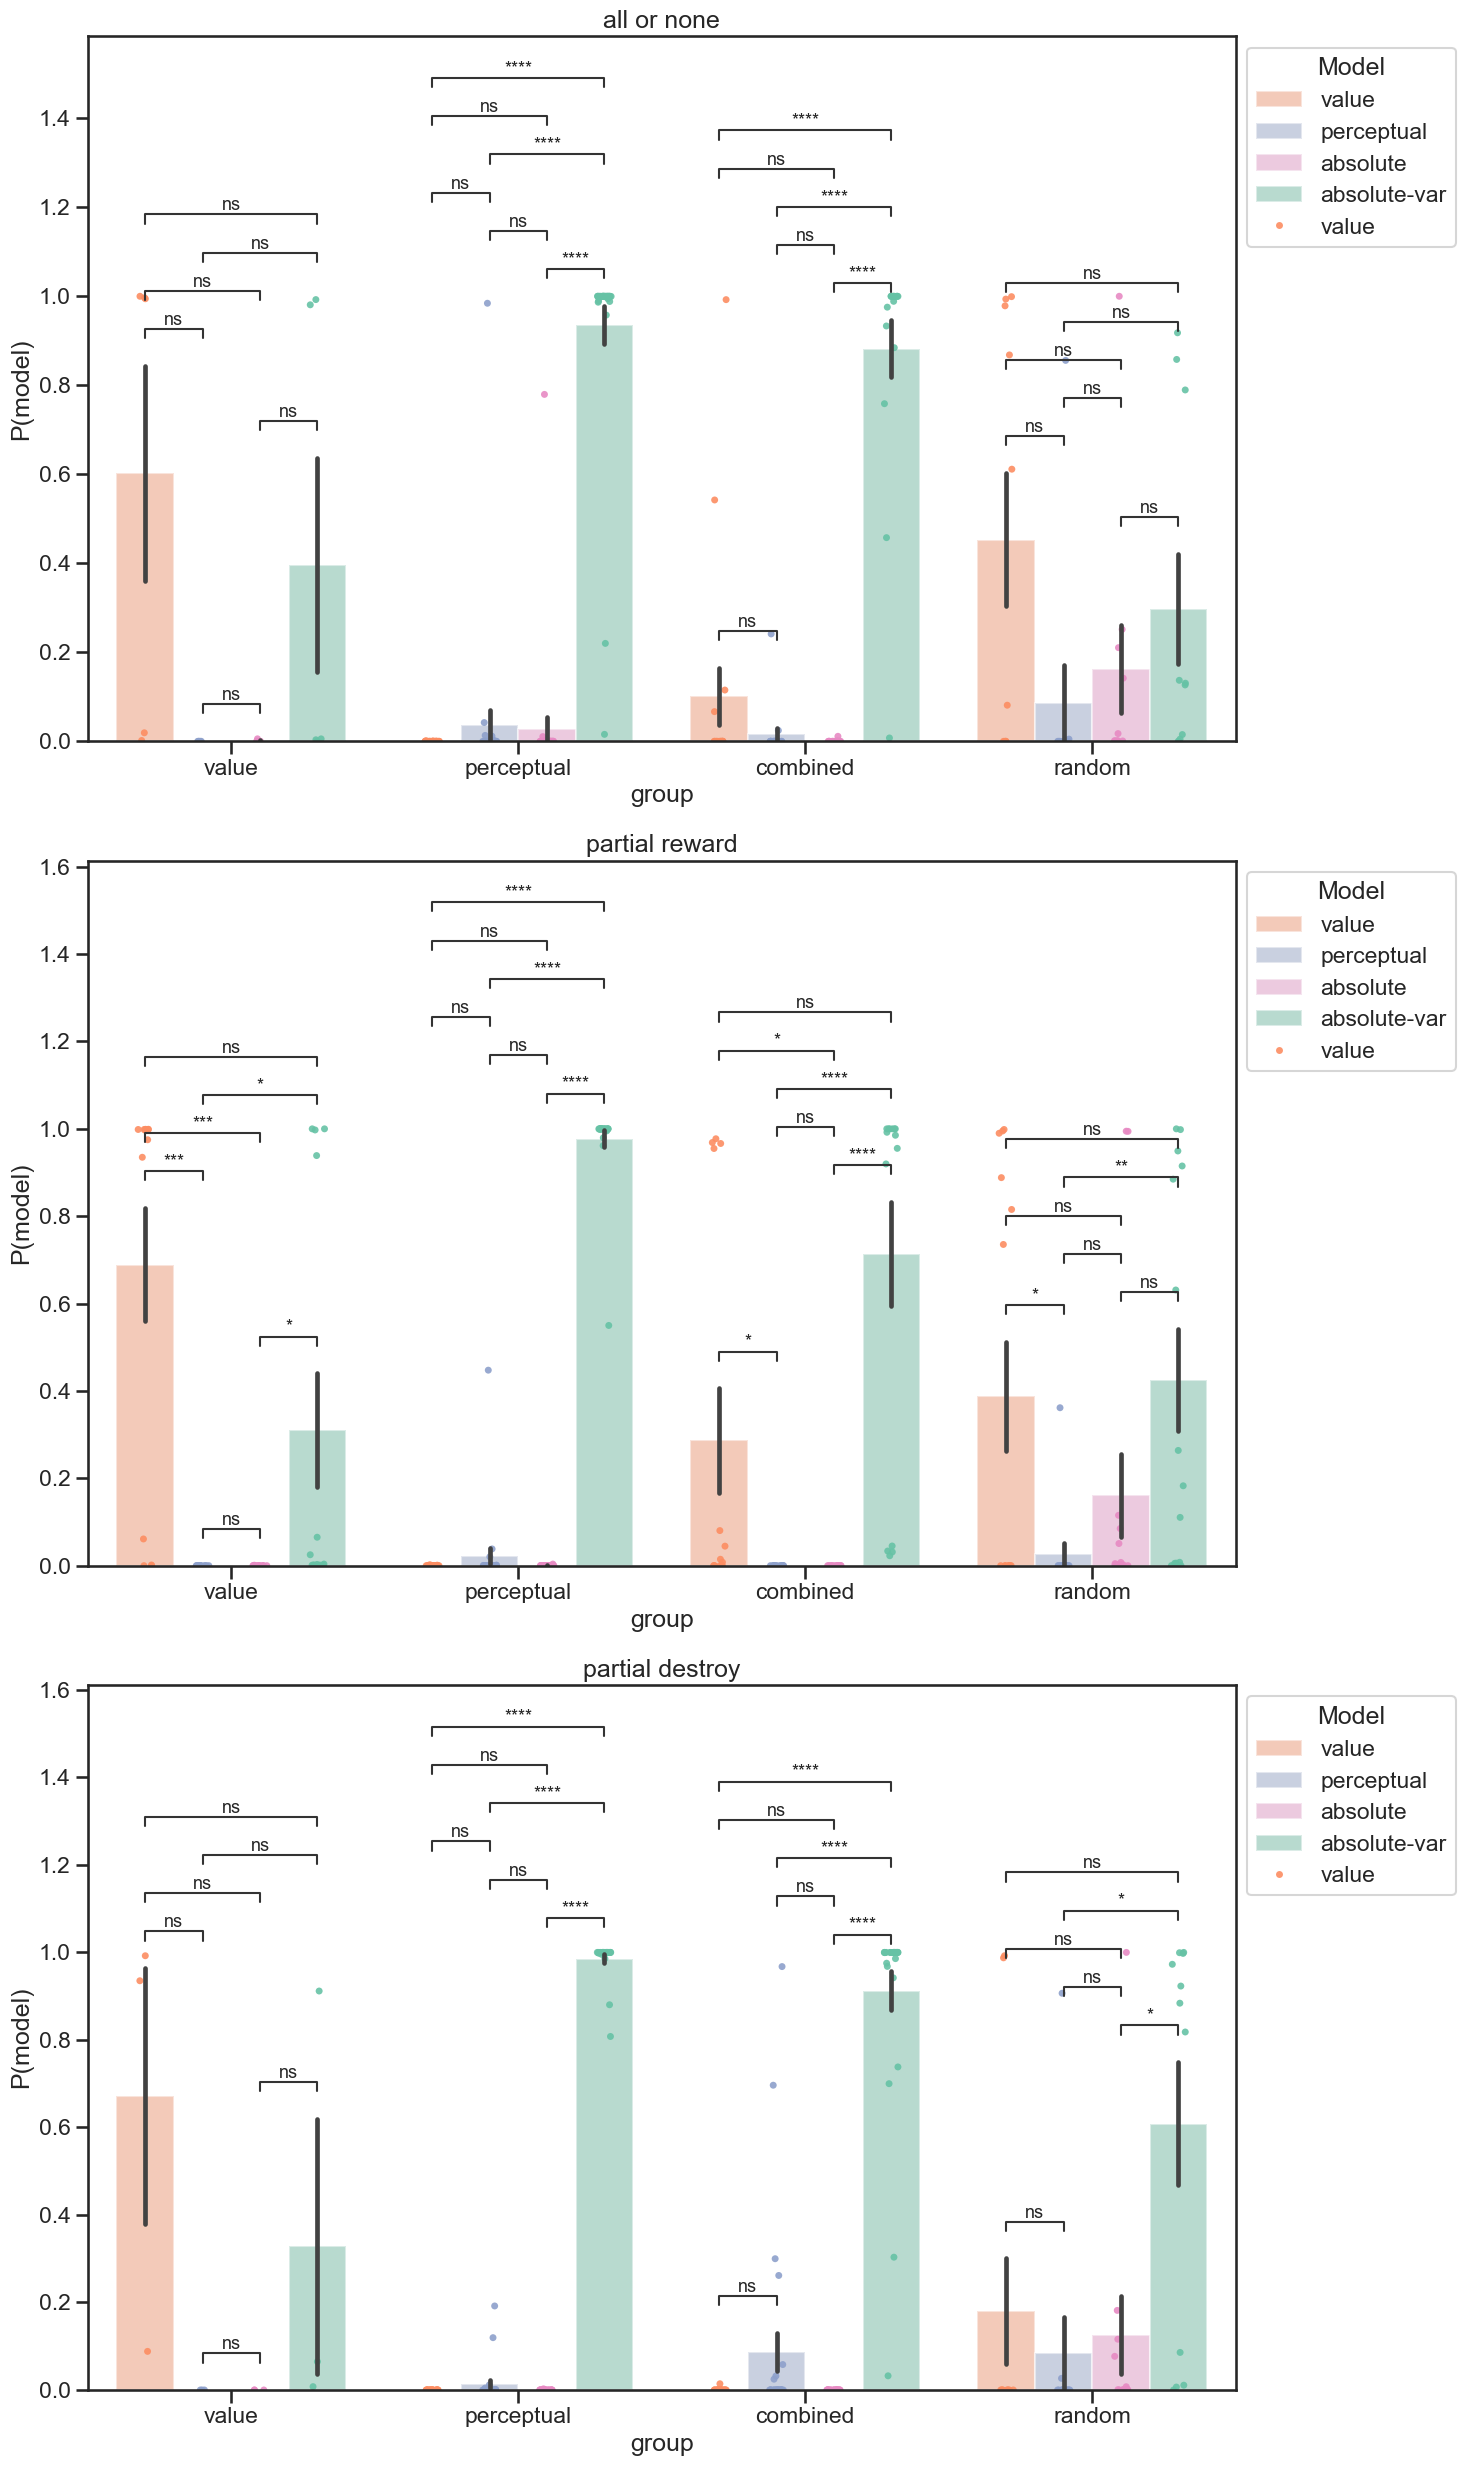

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    # df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic

by_pid = dd.groupby(['agent', 'expName', 'model','group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

x = ['value', 'perceptual', 'combined', 'random']
hues = ['value', 'perceptual', 'absolute', 'absolute-var']
L = create_array(x=x,
                  hue=hues, df=by_pid)

for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.group==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (15, 25)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')

new_exp ={
    'FullPilot12': 'all or none',
    'FullPilot13': 'partial reward',
    'FullPilot14': 'partial destroy'
}
count = 0
for exp in ['FullPilot12', 'FullPilot13', 'FullPilot14']:
    count+=1
    order = ['value', 'perceptual', 'combined', 'random']
    plt.subplot(3, 1, count)

    # Filter data for a specific experiment (e.g., 'FullPilot13') and plot
    # plt.subplot(1, 2, 1)
    ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
                hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


    x_values = by_pid['group'].unique()
    hue_values = by_pid['model'].unique()
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=by_pid[by_pid.expName==exp], x='group', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
    annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
    annotator.apply_and_annotate()

    sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
                hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    # plt.ylim(200, 600)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')
    

    plt.title(new_exp[exp])
plt.tight_layout()





## model x exp.

C:\Users\garciaba\AppData\Local\Temp\ipykernel_13120\136590450.py:74: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(data=by_pid, x='expName', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FullPilot13_perceptual vs. FullPilot13_absolute: t-test paired samples, P_val:4.261e-01 t=-8.011e-01
FullPilot13_value vs. FullPilot13_perceptual: t-test paired samples, P_val:9.686e-01 t=3.957e-02
FullPilot14_perceptual vs. FullPilot14_absolute: t-test paired samples, P_val:7.097e-01 t=3.739e-01
FullPilot14_value vs. FullPilot14_perceptual: t-test paired samples, P_val:7.049e-08 t=-6.092e+00
FullPilot12_perceptual vs. FullPilot12_absolute: t-test paired samples, P_val:9.976e-03 t=-2.661e+00
FullPilot12_value vs. FullPilot12_perceptual: t-test paired samples, P_val:6.704e-01 t=-4.276e-01
FullPilot13_value vs. FullPilot13_absolute: t-test paired samples, P_val:4.361e-01 t=-7.838e-01
FullPilot14_value vs. FullPilot14_absolute: t-test paired samples, P_val:1.819e-06 t=-5.254e+00
FullPilot12_value vs.

C:\Users\garciaba\AppData\Local\Temp\ipykernel_13120\136590450.py:86: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.stripplot(data=by_pid, x='expName', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,


([<matplotlib.axis.XTick at 0x2d6521f0af0>,
 [Text(0, 0, 'all or none'),
  Text(1, 0, 'partial reward'),
  Text(2, 0, 'partial destroy')])

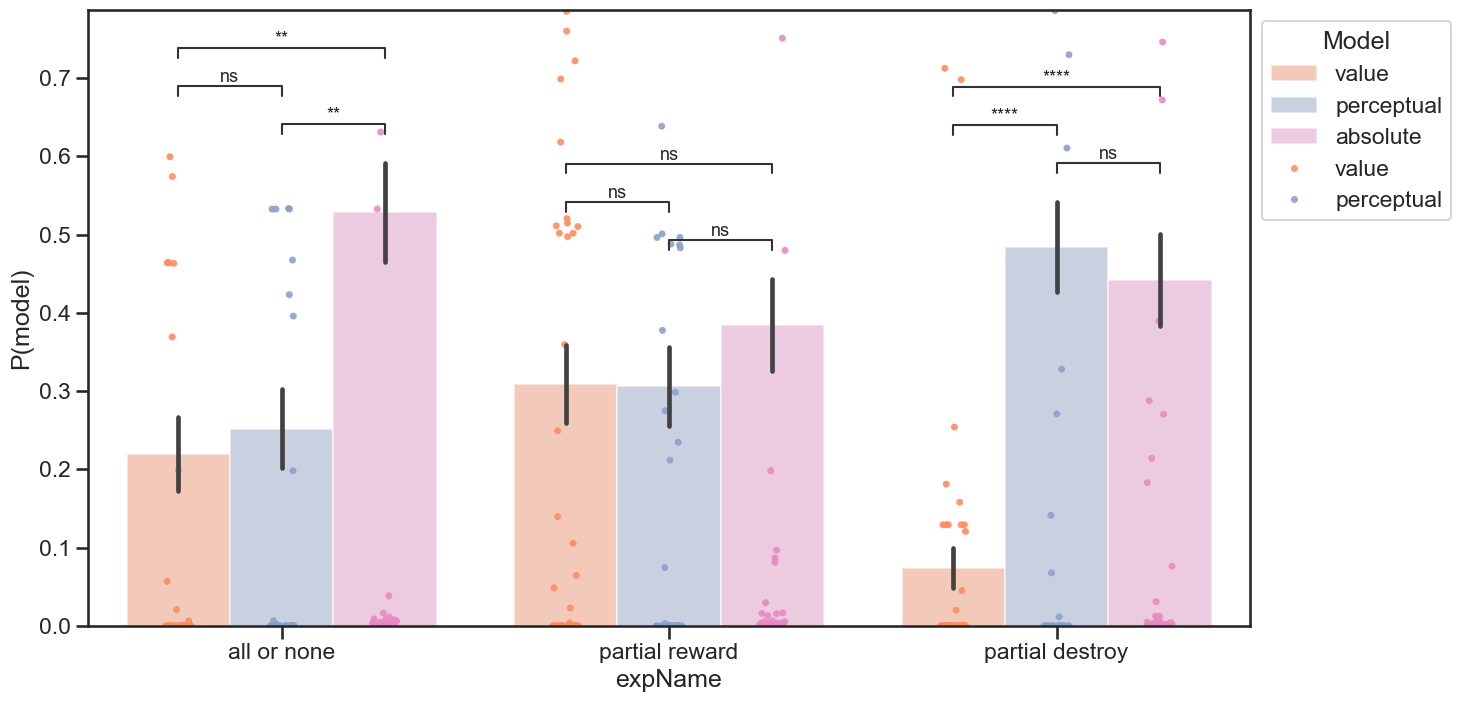

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    if df.get('param2') is not None:
        df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.expName==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic




# Assuming 'df' and 'dd' are your original DataFrame and Dask DataFrame
# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd.groupby(['expName', 'agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
# by_pid['model'] = by_pid['model'].map({'single': '$1 \\beta$', 'log-ratio': '$2 \\beta$'})
# by_pid['model'] = by_pid['model'].map({'independent': 'absolute', 'single': 'single', 'log-ratio': 'log-ratio'})
# Ensure that 'll' contains negative log likelihood and compute BIC
bic = compute_bic(by_pid)

# Add BIC to the DataFrame
by_pid['BIC'] = bic

from groupBMC.groupBMC import GroupBMC

x = ['FullPilot12', 'FullPilot13', 'FullPilot14']   
hues = ['value', 'perceptual', 'absolute']
L = create_array(x=x,
                  hue=hues, df=by_pid)


for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.expName==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (15, 8)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = x

# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='expName', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


x_values = by_pid['expName'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='expName', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
annotator.apply_and_annotate()

sns.stripplot(data=by_pid, x='expName', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
# plt.ylim(200, 600)

# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')
plt.xticks([0, 1, 2], ['all or none', 'partial reward', 'partial destroy'])



#  delta stripplot with colors from group

Text(0, 0.5, '$\\beta_{P} - \\beta_{V}$')

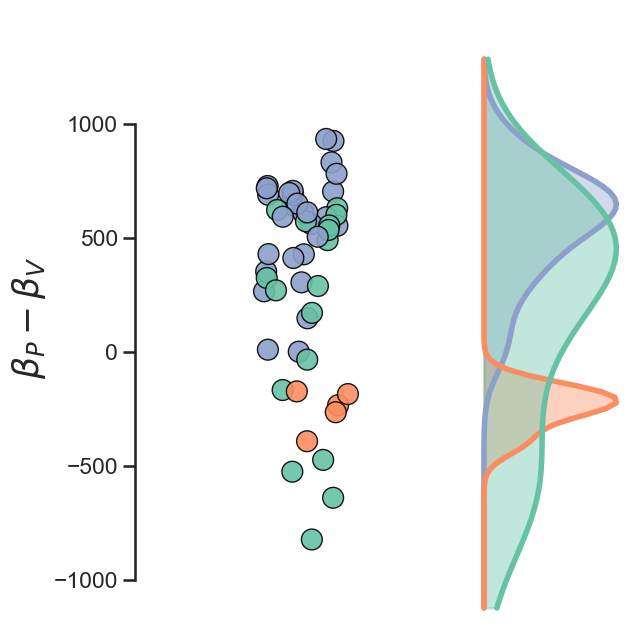

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns

beta_ss = dd[dd.param2=='beta_ss']
beta_ff = dd[dd.param2=='beta_ff']
agent = beta_ss.agent.values
expName = beta_ss.expName.values
group = beta_ss.group.values
model = beta_ss.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'beta_ff': beta_ff.value.values,
    'beta_ss': beta_ss.value.values,
    'll': beta_ss.ll.values,
    'delta': beta_ff.value.values - beta_ss.value.values
})

dd2 = dd2[(dd2.group!='random') & (dd2.expName=='FullPilot12') & (dd2.group.isin(['value', 'perceptual', 'combined']))]

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set({'figure.figsize': (5, 8), 'figure.dpi': 100})
sns.set_style('ticks')
sns.set_context('talk')

# Create a figure with enough width

# Set positions for dots and KDE to be closer together
dot_position = 1
kde_start = 0.4

# Draw the stripplot on the left
sns.stripplot(data=dd2, x=np.ones(len(dd2))*dot_position, y='delta', hue='group', 
              hue_order=['perceptual', 'value', 'combined'], 
              palette=palette, edgecolor='black', size=15, linewidth=1, alpha=0.9)

plt.ylim(-1100, 1100)

# Draw vertical KDE on the right with peaks facing right
for i, group_name in enumerate(['perceptual', 'value', 'combined']):
    subset = dd2[dd2.group == group_name]
    # Use gaussian_kde for more control over the orientation
    kde = stats.gaussian_kde(subset['delta'].values)
    x_pts = np.linspace(dd2.delta.min()-300, dd2.delta.max()+350, 100)
    density = kde(x_pts)
    # Scale density for visibility
    max_density = density.max()
    scaled_density = density / max_density * 0.3  # Scale to make it visible but not too wide
    # Plot the KDE curve horizontally
    plt.fill_betweenx(x_pts, kde_start, kde_start + scaled_density, color=palette[i], alpha=0.4)
    plt.plot(kde_start + scaled_density, x_pts, color=palette[i], lw=4)

# plt.ylim(min(x_pts) - 100, max(x_pts) + 100)  # Add padding to y-limits to show full distribution
# Set x-axis limits to fit the visualization with less empty space
# plt.xlim(0.5, kde_start + 1.0)
plt.xticks([], [])
plt.ylim(-1200, 1500)
# now cut the y-axis at 1000
plt.yticks(np.arange(-1000, 1500, 500), fontsize=20)
# Add a legend only once
handles, labels = plt.gca().get_legend_handles_labels()
# legend outside the plot
plt.legend(handles[:3], labels[:3], title='behavioral group', bbox_to_anchor=(1, 1), loc='upper left')
plt.legend().remove()
sns.despine(trim=True, bottom=True, offset=80)
plt.xlabel('')
plt.ylabel('$\\beta_{P} - \\beta_{V}$', fontdict={'fontsize': 25})

In [48]:
delta.value

0       630.318195
3        85.410175
6      -999.949219
9      -849.595437
12     1000.000000
          ...     
555    -268.511060
558     432.597122
561     999.994904
564    -109.879593
567     811.718266
Name: value, Length: 190, dtype: float64

Text(0, 0.5, '$\\delta_{P>V}$')

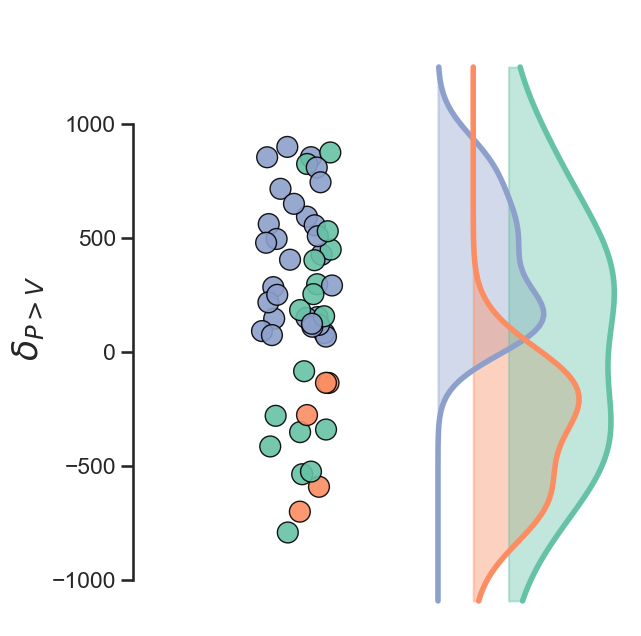

In [ ]:
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns
dd= pd.read_csv('../data/processed/omega_model_FullPilot12_prior_beta_50.csv')
delta = dd[dd.param2=='delta']
agent = delta.agent.values
expName = delta.expName.values
group = delta.group.values
model = delta.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'delta': delta.value,
    'll': delta.ll.values,
})

dd2 = dd2[(dd2.group!='random') & (dd2.expName=='FullPilot12') & (dd2.group.isin(['value', 'perceptual', 'combined']))]

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set({'figure.figsize': (5, 8), 'figure.dpi': 100})
sns.set_style('ticks')
sns.set_context('talk')

# Create a figure with enough width

# Set positions for dots and KDE to be closer together
dot_position = 1
kde_start = 0.4

# Draw the stripplot on the left
sns.stripplot(data=dd2, x=np.ones(len(dd2))*dot_position, y='delta', hue='group', 
              hue_order=['perceptual', 'value', 'combined'], 
              palette=palette, edgecolor='black', size=15, linewidth=1, alpha=0.9)

plt.ylim(-1100, 1100)

# Draw vertical KDE on the right with peaks facing right
for i, group_name in enumerate(['perceptual', 'value', 'combined']):
    subset = dd2[dd2.group == group_name]
    # Use gaussian_kde for more control over the orientation
    kde = stats.gaussian_kde(subset['delta'].values)
    x_pts = np.linspace(dd2.delta.min()-300, dd2.delta.max()+350, 100)
    density = kde(x_pts)
    # Scale density for visibility
    max_density = density.max()
    scaled_density = density / max_density * 0.3  # Scale to make it visible but not too wide
    # Plot the KDE curve horizontally
    plt.fill_betweenx(x_pts, kde_start, kde_start + scaled_density, color=palette[i], alpha=0.4)
    plt.plot(kde_start + scaled_density, x_pts, color=palette[i], lw=4)
    # add space between each kde
    kde_start += 0.1 # Adjust this value to control the spacing between KDEs

# plt.ylim(min(x_pts) - 100, max(x_pts) + 100)  # Add padding to y-limits to show full distribution
# Set x-axis limits to fit the visualization with less empty space
# plt.xlim(0.5, kde_start + 1.0)
plt.xticks([], [])
plt.ylim(-1200, 1500)
# now cut the y-axis at 1000
plt.yticks(np.arange(-1000, 1500, 500), fontsize=20)
# Add a legend only once
handles, labels = plt.gca().get_legend_handles_labels()
# legend outside the plot
plt.legend(handles[:3], labels[:3], title='behavioral group', bbox_to_anchor=(1, 1), loc='upper left')
plt.legend().remove()
sns.despine(trim=True, bottom=True, offset=80)
plt.xlabel('')
plt.ylabel('$\\delta_{P>V}$', fontdict={'fontsize': 25})

array(['perceptual', 'perceptual', 'random', 'random', 'combined',
       'combined', 'perceptual', 'random', 'perceptual', 'random',
       'perceptual', 'perceptual', 'random', 'perceptual', 'perceptual',
       'random', 'perceptual', 'perceptual', 'perceptual', 'perceptual',
       'combined', 'random', 'perceptual', 'perceptual', 'combined',
       'combined', 'value', 'random', 'perceptual', 'random', 'combined',
       'value', 'perceptual', 'perceptual', 'perceptual', 'perceptual',
       'combined', 'combined', 'value', 'perceptual', 'combined',
       'perceptual', 'perceptual', 'combined', 'combined', 'perceptual',
       'perceptual', 'perceptual', 'combined', 'combined', 'combined',
       'combined', 'combined', 'perceptual', 'perceptual', 'value',
       'perceptual', 'combined', 'perceptual', 'random', 'value'],
      dtype=object)

Text(0, 0.5, '$\\omega$')

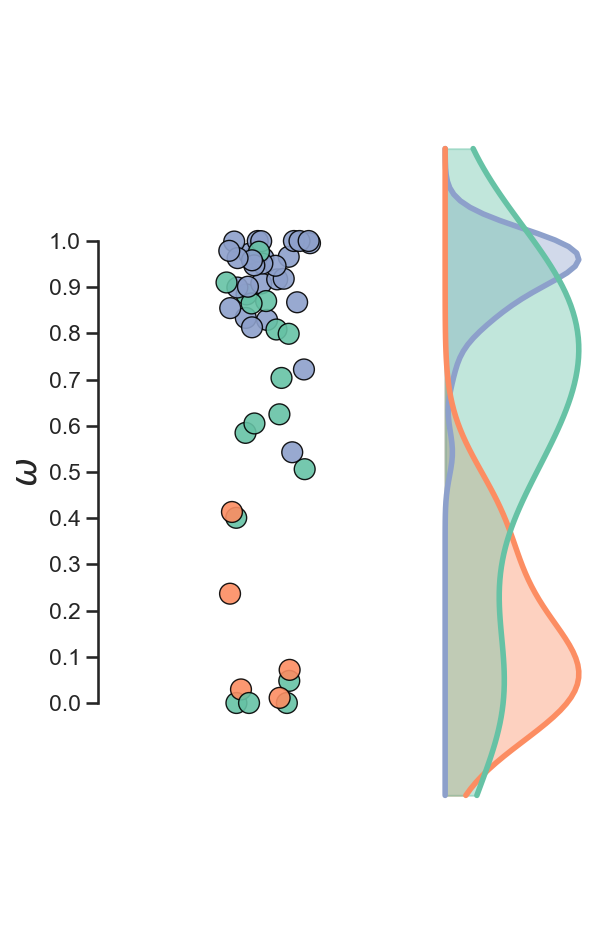

In [47]:
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns
delta = pd.read_csv('../data/processed/omega_model_FullPilot12_prior_beta_50.csv')

agent = delta.agent.values
expName = ['FullPilot12']*len(delta)
group = delta.group.values
model = delta.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'delta': delta.omega.values,
    'll': delta.ll.values,
})

dd2 = dd2[(dd2.group!='random') & (dd2.expName=='FullPilot12') & (dd2.group.isin(['value', 'perceptual', 'combined']))]

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set({'figure.figsize': (5, 12), 'figure.dpi': 100})
sns.set_style('ticks')
sns.set_context('talk')

# Create a figure with enough width

# Set positions for dots and KDE to be closer together
dot_position = 1
kde_start = 0.4

# Draw the stripplot on the left
sns.stripplot(data=dd2, x=np.ones(len(dd2))*dot_position, y='delta', hue='group', 
              hue_order=['perceptual', 'value', 'combined'], 
              palette=palette, edgecolor='black', size=15, linewidth=1, alpha=0.9)

plt.ylim(-.5, 1.5)

# Draw vertical KDE on the right with peaks facing right
for i, group_name in enumerate(['perceptual', 'value', 'combined']):
    subset = dd2[dd2.group == group_name]
    # Use gaussian_kde for more control over the orientation
    kde = stats.gaussian_kde(subset['delta'].values)
    x_pts = np.linspace(dd2.delta.min()-0.2, dd2.delta.max()+0.2, 100)
    density = kde(x_pts)
    # Scale density for visibility
    max_density = density.max()
    scaled_density = density / max_density * 0.3  # Scale to make it visible but not too wide
    # Plot the KDE curve horizontally
    plt.fill_betweenx(x_pts, kde_start, kde_start + scaled_density, color=palette[i], alpha=0.4)
    plt.plot(kde_start + scaled_density, x_pts, color=palette[i], lw=4)
    # add space between each kde
    # kde_start += 0.1 # Adjust this value to control the spacing between KDEs

# plt.ylim(min(x_pts) - 100, max(x_pts) + 100)  # Add padding to y-limits to show full distribution
# Set x-axis limits to fit the visualization with less empty space
# plt.xlim(0.5, kde_start + 1.0)
plt.xticks([], [])
plt.ylabel('$\\omega$')
# plt.ylim(-1200, 1500)
# now cut the y-axis at 1000
plt.yticks(np.arange(0, 1.1, .1), fontsize=20)
# Add a legend only once
handles, labels = plt.gca().get_legend_handles_labels()
# legend outside the plot
plt.legend(handles[:3], labels[:3], title='behavioral group', bbox_to_anchor=(1, 1), loc='upper left')
plt.legend().remove()
sns.despine(trim=True, bottom=True, offset=80)
plt.xlabel('')
plt.ylabel('$\\omega$', fontdict={'fontsize': 25})

In [ ]:
df[(df.session==1) & (df.t==48)].opti_ff.mean()

0.2894736842105263

In [ ]:
# nsub
dd2.groupby('agent').size().value_counts()

1    155
Name: count, dtype: int64

C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)


IndexError: cannot do a non-empty take from an empty axes.

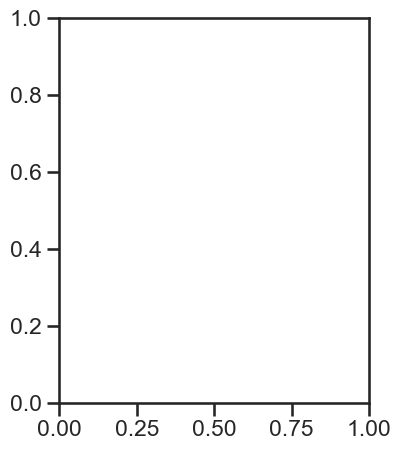

In [ ]:
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns

beta_ss = dd[dd.param2=='beta_ss']
beta_ff = dd[dd.param2=='beta_ff']
agent = beta_ss.agent.values
expName = beta_ss.expName.values
group = beta_ss.group.values
model = beta_ss.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'beta_ff': beta_ff.value.values,
    'beta_ss': beta_ss.value.values,
    'll': beta_ss.ll.values,
    'delta': beta_ff.value.values - beta_ss.value.values
})

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set_style('ticks')
sns.set_context('talk')

# i want also a kde region highlight (zone) of the delta values
sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
sns.stripplot(data=dd2, x=1, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, edgecolor='black', size=10)

In [100]:
dd = pd.read_csv('../data/processed/fit_params_full_latest_fixed_wv.csv')


## Pooled


[('absolute', 'absolute-var')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

absolute vs. absolute-var: t-test paired samples, P_val:8.683e-32 t=1.426e+01


C:\Users\basil\AppData\Local\Temp\ipykernel_11868\4109932496.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=by_pid, x='model', y='BIC', errorbar='se', alpha=0.5, zorder=-1, order=order,
C:\Users\basil\AppData\Local\Temp\ipykernel_11868\4109932496.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=by_pid, x='model', y='BIC', alpha=0.9, zorder=1,order=order, size=5, clip_on=False,


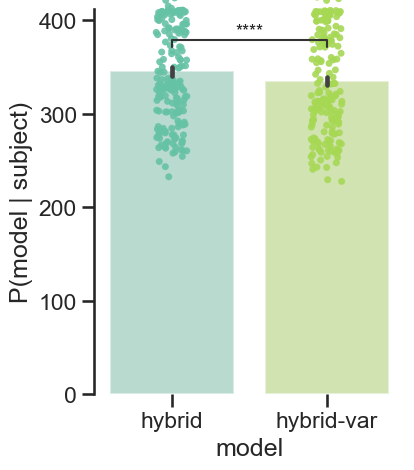

In [105]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in itertools.combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result


# Group by the necessary columns and compute first
by_pid = dd.groupby(['expName', 'agent', 'model']).ll.first().reset_index()
by_pid = by_pid[by_pid.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14'])]
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

models = ['value', 'perceptual', 'absolute']
models = ['absolute', 'absolute-var']
L = []
for m in models:
  L.append(-by_pid[by_pid.model==m].BIC.values)

L = np.array(L)
results = GroupBMC(L).get_result()

for i, m in enumerate(models):
    by_pid.loc[(by_pid.model==m), 'P(model)'] = results.attribution[i]


sns.set({'figure.figsize': (4, 5)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = models
palette = ['C0', 'C4']
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='model', y='BIC', errorbar='se', alpha=0.5, zorder=-1, order=order,
 palette=palette)


pairs = list(itertools.combinations(models, 2))


print(pairs)
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='BIC', order=order, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
annotator.apply_and_annotate()

# no cut off
sns.stripplot(data=by_pid, x='model', y='BIC', alpha=0.9, zorder=1,order=order, size=5, clip_on=False, 
            palette=palette)	
plt.xticks([0, 1], ['hybrid', 'hybrid-var'])
plt.ylabel('P(model | subject)')
# get handles
# handles,_ = ax.get_legend_handles_labels()
# # plt.xticks([], [])
# plt.xlabel('')
sns.despine(bottom=True)
# plt.ylim(0, 1)
# plt.ylim(200, 650)

# plt.title(new_exp[exp])
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(bbox_to_anchor=(1, 1), handles=handles, labels=['value-bayes', 'perceptual-bayes', 'hybrid-bayes'], title='Model', loc='upper left')




In [ ]:
handles

[]

In [ ]:
# paired t-test
import scipy.stats as stats


x = by_pid[by_pid.model=='absolute']['P(model)']
y = by_pid[by_pid.model=='perceptual']['P(model)']

stats.ttest_rel(x, y)

Ttest_relResult(statistic=1.691860363072655, pvalue=0.09232063290199759)

# BIC

## group x model

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute-var vs. combined_random: t-test paired samples, P_val:6.263e-47 t=-4.632e+01
random_absolute-var vs. random_random: t-test paired samples, P_val:3.845e-06 t=-5.500e+00
random_value vs. random_perceptual: t-test paired samples, P_val:1.726e-01 t=-1.393e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:8.477e-31 t=1.929e+01
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:4.934e-07 t=5.671e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:2.448e-07 t=7.621e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:1.079e-10 t=1.216e+01
value_absolute-var vs. value_random: t-test paired samples, P_val:1.144e-11 t=-1.378e+01
value_value vs. value_perceptual: t-test paired samples, P_val:1.905e-10 

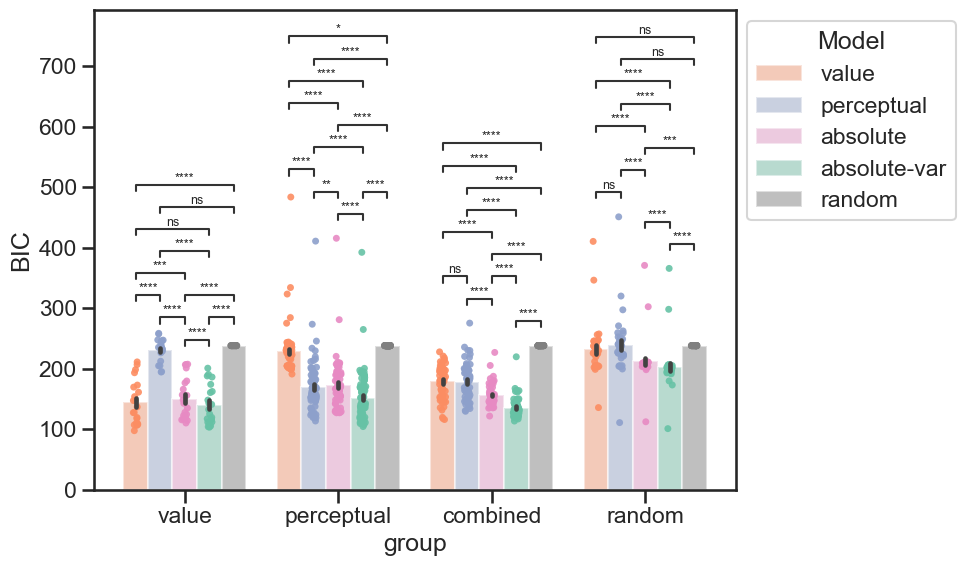

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    final_array = []
    for i in x:
        for j in hue:
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)

    return final_array



by_pid = dd.groupby(['agent', 'model', 'group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)


from groupBMC.groupBMC import GroupBMC

L = create_array(x=by_pid.group.unique(), hue=by_pid.model.unique(), df=by_pid)
hues = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']

sns.set({'figure.figsize': (10, 6)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined', 'random']
count = 0
count += 1
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
sns.barplot(data=by_pid, x='group', y='BIC', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
ax = sns.stripplot(data=by_pid, x='group', y='BIC', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


x_values = by_pid['group'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='group', y='BIC', order=order, hue='model', hue_order=hues, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=9)
annotator.apply_and_annotate()

# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')


# put legend outside the plot

# plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
plt.tight_layout()
#change mo

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Group x model x exp

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute-var vs. combined_random: t-test paired samples, P_val:5.843e-08 t=-9.468e+00
random_absolute-var vs. random_random: t-test paired samples, P_val:8.637e-01 t=1.766e-01
random_value vs. random_perceptual: t-test paired samples, P_val:1.334e-02 t=-3.071e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:5.904e-13 t=1.248e+01
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:7.682e-03 t=3.047e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:1.881e-02 t=3.818e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:1.416e-02 t=4.159e+00
value_absolute-var vs. value_random: t-test paired samples, P_val:4.752e-02 t=-2.826e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.472e-02 t

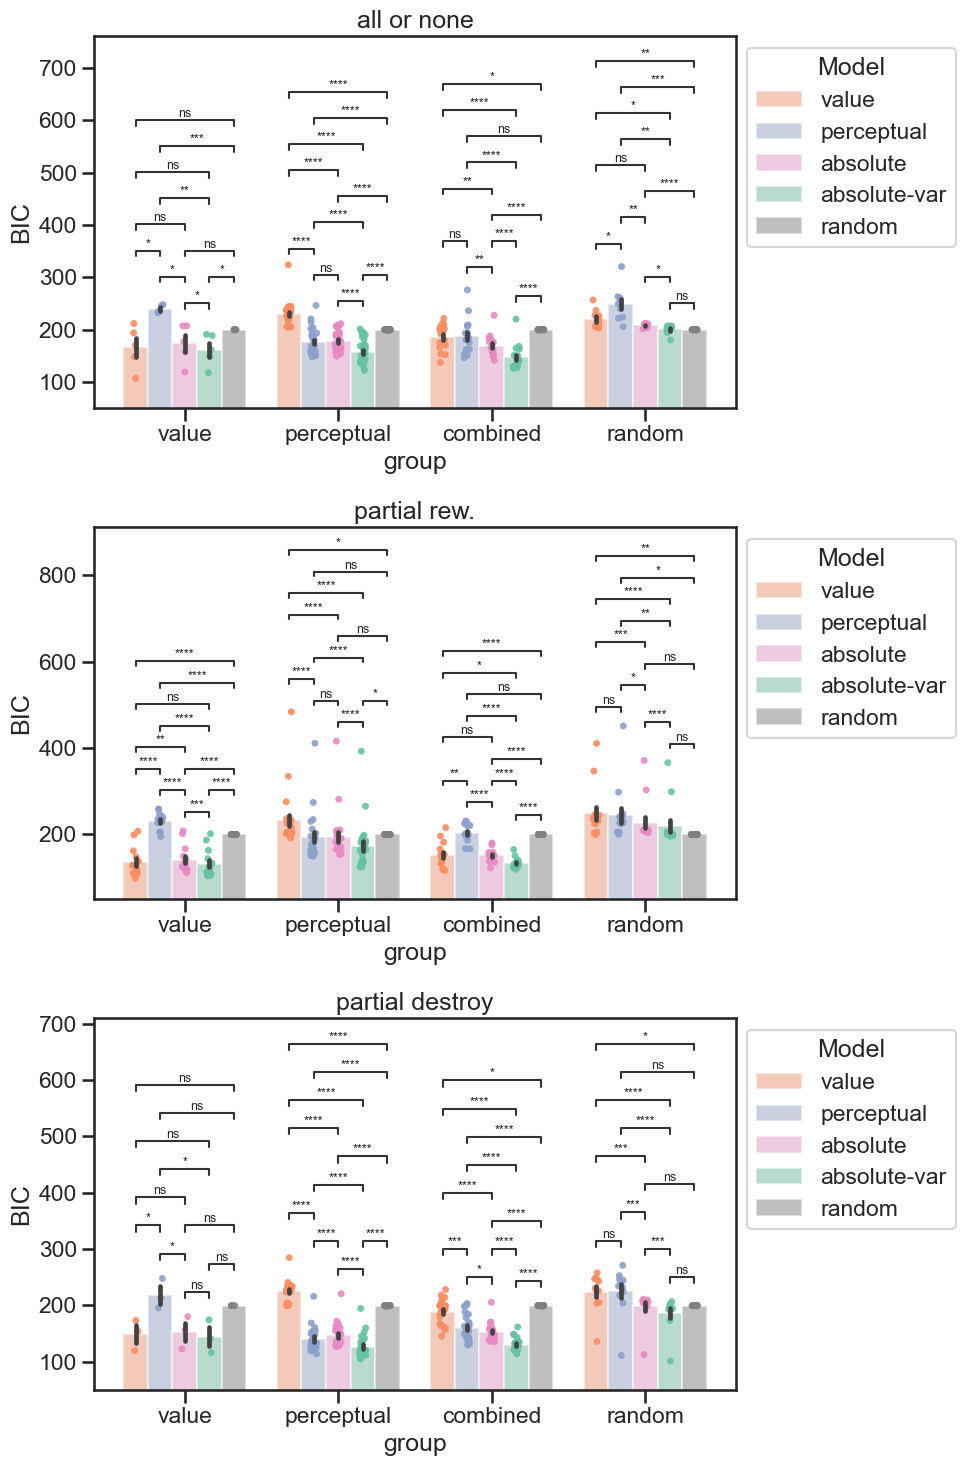

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result


# Group by the necessary columns and compute first
by_pid = dd.groupby(['agent', 'model', 'expName', 'group']).ll.first().reset_index()

by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (10, 15)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined', 'random']
hue_order = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']
count = 0
for exp in ['FullPilot12', 'FullPilot13', 'FullPilot14']:
    count += 1
    plt.subplot(3, 1, count)
    # Filter data for a specific experiment (e.g., 'FullPilot13') and plot
    # plt.subplot(1, 2, 1)
    sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='BIC', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
             hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    ax = sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='BIC', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
              hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    plt.ylim(50, 600)

    x_values = by_pid['group'].unique()
    hue_values = by_pid['model'].unique()
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=by_pid[by_pid.expName==exp], x='group', y='BIC', order=order, hue='model', hue_order=hue_order, loc='inside')
    annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=9)
    annotator.apply_and_annotate()
    new_exp = {
        'FullPilot12': 'all or none',
        'FullPilot13': 'partial rew.',
        'FullPilot14': 'partial destroy'
    }
    plt.title(new_exp[exp])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')


# put legend outside the plot

# plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
plt.tight_layout()
#change mo

# all pooled across models

In [ ]:
dd.groupby('model').size()

model
absolute-var      380
perceptual-var    190
value-var         190
dtype: int64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

absolute vs. absolute-var: t-test paired samples with Bonferroni correction, P_val:7.010e-06 t=5.543e+00
absolute-var vs. value: t-test paired samples with Bonferroni correction, P_val:1.793e-09 t=-7.670e+00
perceptual vs. perceptual-var: t-test paired samples with Bonferroni correction, P_val:7.306e-05 t=4.911e+00
value vs. perceptual: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=1.262e+00
absolute vs. value: t-test paired samples with Bonferroni correction, P_val:1.311e-07 t=-6.577e+00
absolute-var vs. perceptual: t-test paired samples with Bonferroni correction, P_val:1.942e-07 t=-6.476e+00
value vs. perceptual-var: t-test paired samples with Bonferroni correction, P_val:1.976e-01 t=2.395e+00
absolute vs. perceptual: t-test paired samples with Bonferroni correction, P_val

C:\Users\garciaba\AppData\Local\Temp\ipykernel_38776\3389674718.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_38776\3389674718.py:24: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_38776\3389674718.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.st

Text(0.5, 11.98958333333333, '')

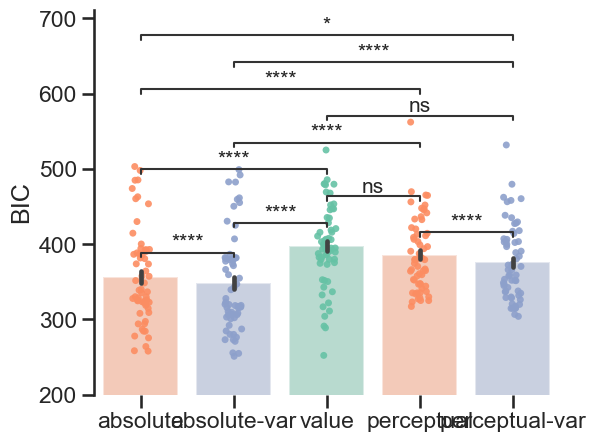

In [ ]:
# Group by the necessary columns and compute first


# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd[dd.expName=='FullPilot12'].groupby(['agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (6, 5)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

# hues = ['value', 'perceptual', 'absolute', 'absolute-var']
# hues = ['absolute-var', 'value-var', 'perceptual-var']
hues = ['value', 'perceptual', 'absolute']

hues = ['absolute', 'absolute-var', 'value', 'perceptual', 'perceptual-var']
palette = ['C1', 'C2', 'C0']
# palette = ['C1', 'C2', 'C3', 'C0', 'grey']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             order=hues, palette=palette)

plt.ylim(200, 500)
sns.despine()

x_values = by_pid['model'].unique()

# hue_values = by_pid['expName'].unique()
import itertools
pairs = list(itertools.combinations(x_values, 2))

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='BIC', order=hues)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  y='BIC', x='model',alpha=0.9, zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              order=hues, palette=palette, clip_on=False)
# plt.legend().remove()
sns.despine(bottom=True)
# plt.xticks([], [])
plt.xlabel('')




In [ ]:
# Group by the necessary columns and compute first

# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd[dd.expName=='FullPilot12'].groupby(['agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (4, 5)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

# hues = ['value', 'perceptual', 'absolute', 'absolute-var']
# hues = ['absolute-var', 'value-var', 'perceptual-var']
hues = ['value', 'perceptual', 'absolute']
palette = ['C1', 'C2', 'C0']


from groupBMC.groupBMC import GroupBMC

x = ['FullPilot12', 'FullPilot13', 'FullPilot14']   
hues = ['value', 'perceptual', 'absolute']
L = create_array(x=x,
                  hue=hues, df=by_pid)


for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.expName==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]
# palette = ['C1', 'C2', 'C3', 'C0', 'grey']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             order=hues, palette=palette)

plt.ylim(200, 500)
sns.despine()

x_values = by_pid['model'].unique()

# hue_values = by_pid['expName'].unique()
import itertools
pairs = list(itertools.combinations(x_values, 2))

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='BIC', order=hues)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  y='BIC', x='model',alpha=0.9, zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              order=hues, palette=palette, clip_on=False)
# plt.legend().remove()
sns.despine(bottom=True)
plt.xticks([], [])
plt.xlabel('')




C:\Users\basil\AppData\Local\Temp\ipykernel_5712\2550469991.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]


AttributeError: 'DataFrame' object has no attribute 'expName'

In [ ]:
dd.to_csv('../data/processed/fit_params_absolute_var_zscore.csv', index=False)

## model x exp

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FullPilot14_absolute-var vs. FullPilot14_random: t-test paired samples with Bonferroni correction, P_val:1.127e-32 t=-2.443e+01
FullPilot13_absolute vs. FullPilot13_absolute-var: t-test paired samples with Bonferroni correction, P_val:1.632e-13 t=1.021e+01
FullPilot14_perceptual vs. FullPilot14_absolute: t-test paired samples with Bonferroni correction, P_val:9.357e-04 t=4.483e+00
FullPilot12_absolute vs. FullPilot12_absolute-var: t-test paired samples with Bonferroni correction, P_val:3.233e-19 t=1.409e+01
FullPilot12_perceptual vs. FullPilot12_absolute: t-test paired samples with Bonferroni correction, P_val:1.466e-06 t=6.239e+00
FullPilot12_absolute-var vs. FullPilot12_random: t-test paired samples with Bonferroni correction, P_val:5.466e-26 t=-1.934e+01
FullPilot12_value vs. FullPilot12_percep

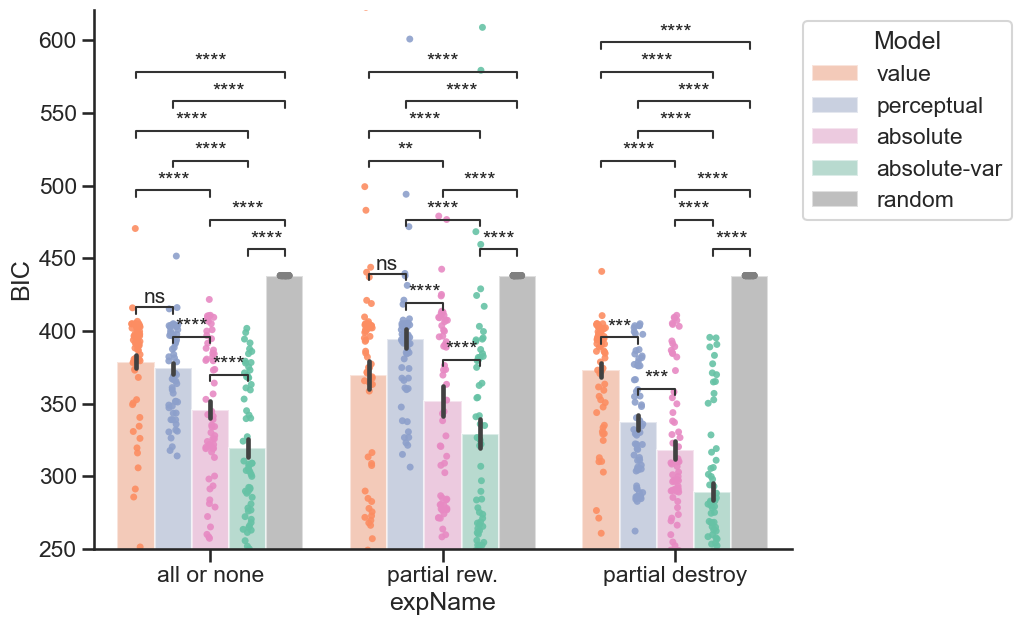

In [ ]:
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first

by_pid = dd.groupby(['agent', 'expName', 'model']).ll.first().reset_index()

# model independent should be named absolute
# by_pid['model'] = by_pid['model'].map({'independent': 'absolute', 'single': 'single', 'log-ratio': 'log-ratio'})

by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (9, 7)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
# order = ['value', 'perceptual', 'combined', 'random']
order = ['FullPilot12', 'FullPilot13', 'FullPilot14']
hue_order = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC',x='expName', hue='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'], order=order)

plt.ylim(250, 475)
sns.despine()

x_values = by_pid['expName'].unique()
hue_values = by_pid['model'].unique()
# pairs = list(itertools.combinations(x_values, 2))
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='expName', hue='model', y='BIC', hue_order=hue_order, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  dodge=1, y='BIC', x='expName',alpha=0.9, hue='model', zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'], order=order)
# plt.legend().remove()
plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
# legend is outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), title='Model', loc='upper left', handles=handles[:5], labels=labels[:5])





# Parameters (beta_ss/beta_ff)

2
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual_$\beta_P$ vs. perceptual_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:1.772e-08 t=8.346e+00
value_$\beta_P$ vs. value_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:2.119e-02 t=-5.509e+00
combined_$\beta_P$ vs. combined_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:6.869e-01 t=-1.431e+00
random_$\beta_P$ vs. random_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:8.744e-01 t=-1.323e+00


C:\Users\garciaba\AppData\Local\Temp\ipykernel_38776\2288022985.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param',  dodge=True, ci=68, alpha=.8, zorder=-1, order=order)


Text(0.5, 1.0, 'hybrid-bayes model')

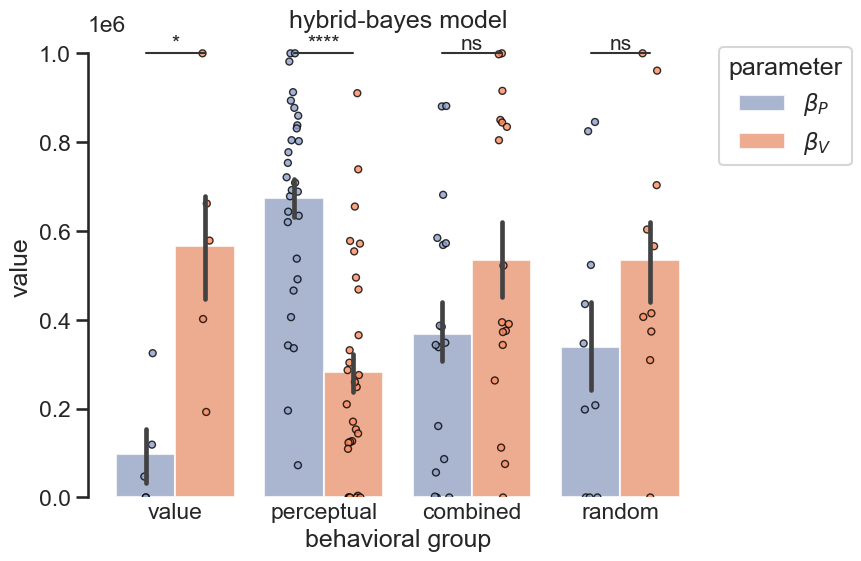

In [ ]:
from statannotations.Annotator import Annotator
def generate_combinations(x, hue):
    from itertools import combinations
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    final_array = []
    for i in x:
        for j in hue:
            array = df[(df.group==i) & (df.model==j)].values
            final_array.append(array)

    return np.array(final_array)



sns.set({'figure.figsize': (8,6), 'figure.dpi': 100})

sns.set_context('talk')
sns.set_style("ticks")
# change palette must be very different from set2
palette = sns.color_palette("Set2")
# only select the first 3 colors
palette = palette[1:3][::-1]
# palette = ['grey']
palette.append('#feabf2')
sns.set_palette(palette)

count_subplot = 0
model = 'absolute-var'
n_param = dd[(dd.model==model)].param2.unique().shape[0]
print(n_param)

# dd['expName'] = dd.expName.map({'FullPilot12': 'all or none', 'FullPilot13': 'partial rew.', 'FullPilot14': 'partial destroy'})
# dd = dd[dd.param2!='beta_ff']
# dd.loc[dd.param=='$\\beta_V$', 'param'] = '$\\beta$'

for expName in ['FullPilot12']:#, 'FullPilot13', 'FullPilot14']:
    count_subplot += 1
    plt.subplot(1, 1, count_subplot)
    sns.set_style("ticks")
    sns.set_context('talk')
    sns.set_palette(palette)
    order = ['value', 'perceptual', 'combined', 'random']
    sns.barplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param',  dodge=True, ci=68, alpha=.8, zorder=-1, order=order)
    ax = sns.stripplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param', jitter=0.1,alpha=.8, dodge=True, edgecolor='black', linewidth=1, zorder=1, order=order)
    plt.ylim(-50, 1050)

    x_values = dd[(dd.expName==expName) & (dd.model == model)]['group'].unique()
    hue_values = dd[(dd.expName==expName) & (dd.model == model)]['param'].unique()
# pairs = list(itertools.combinations(x_values, 2))
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=dd[(dd.expName==expName) & (dd.model == model)], x='group', hue='param', y='value',order=order)
    annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.01, text_offset=0.0001, line_offset_to_group=50, line_offset=50, fontsize=15)

    annotator.apply_and_annotate()

    handles, labels = plt.gca().get_legend_handles_labels()
    # increase the size of the markers

    plt.legend().remove()

    sns.despine(trim=True, bottom=True)
    plt.tick_params(axis='x', length=0)
    if expName=='FullPilot12':
        plt.title('all or none')
    if expName=='FullPilot13':
        plt.title('partial rew.')
    if expName=='FullPilot14':
        plt.title('partial destroy')
    # plt.title(expName)

# plt.legend(handles[2:], labels[2:], title='Parameter', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
# legent horizontal position outside
plt.legend(handles=handles[:n_param], labels=labels[:n_param], title='parameter', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
plt.xlabel('behavioral group')
# legend flat and horizontal

# plt.suptitle('Model: {}'.format(model))
# plt.title('Model: {}'.format(model))
plt.title('hybrid-bayes model')
# plt.tight_layout()

In [ ]:
model = 'absolute'
# avg = df_sim.groupby(['agent', 'model'], as_index=False).mean(numeric_only=True)
avg_sim = df_sim[df_sim.session==3].groupby(['agent', 'model'], as_index=False).mean(numeric_only=True)

avg = df[df.session==3].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

for pid in avg.prolificID.unique():
    avg.loc[avg.prolificID==pid, 'beta_ss'] = avg_sim[(avg_sim.agent==pid) & (avg_sim.model==model)].beta_ss.values[0]
    avg.loc[avg.prolificID==pid, 'beta_ff'] = avg_sim[(avg_sim.agent==pid) & (avg_sim.model==model)].beta_ff.values[0]

# change color of lmplot
colors = sns.color_palette("Set2")
sns.set_palette([colors[1]])
sns.lmplot(x='beta_ss', y='opti_ss', data=avg, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(avg.beta_ss, avg.opti_ss)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{V}$')
plt.ylabel('p(optimal spaceship)') 

In [ ]:
dd = pd.read_csv('../data/processed/fit_params.csv')

Text(52.000000000000014, 0.5, 'p(optimal spaceship)')

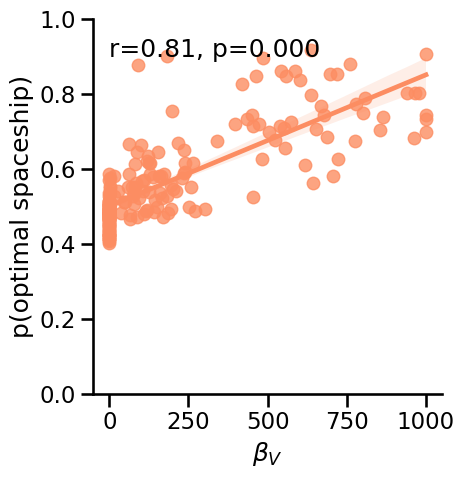

In [ ]:
opti_ss = df.groupby(['prolificID', 'session'], as_index=False).opti_ss.mean()
opti_ff = df.groupby(['prolificID', 'session'], as_index=False).opti_ff.mean()
opti_ss = opti_ss[opti_ss.session==3]
opti_ff = opti_ff[opti_ff.session==3]
param = []

model = 'absolute'
# add the optimal ss to the data dd
for agent in opti_ss.prolificID:
    param.append(
        {
            'opti_ss': opti_ss[opti_ss.prolificID==agent].opti_ss.values[0],  
            'opti_ff': opti_ff[opti_ff.prolificID==agent].opti_ff.values[0],
            'agent': agent,
            'model': model,
            'beta_ff': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ff')].value.values[0],
            'beta_ss': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ss')].value.values[0],
        }
    )

param = pd.DataFrame(param)

# remove the cutoff
# change color of lmplot
colors = sns.color_palette("Set2")
sns.set_context('talk')
sns.set_palette([colors[1]])
sns.lmplot(x='beta_ss', y='opti_ss', data=param, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(param.beta_ss, param.opti_ss)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{V}$')
plt.ylabel('p(optimal spaceship)') 

Text(0.5, 49.99999999999997, '$\\delta_{P>V}$')

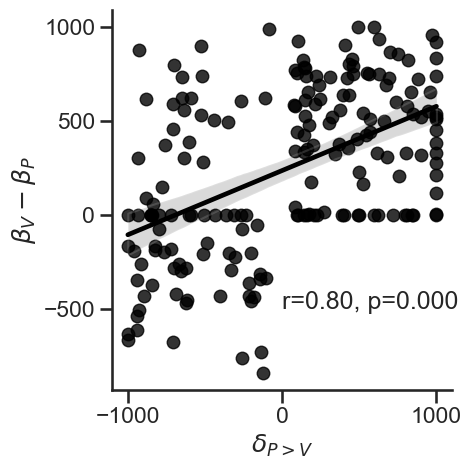

In [74]:
opti_ss = df.groupby(['prolificID', 'session'], as_index=False).opti_ss.mean()
opti_ff = df.groupby(['prolificID', 'session'], as_index=False).opti_ff.mean()
opti_ss = opti_ss[opti_ss.session==3]
opti_ff = opti_ff[opti_ff.session==3]
param = []

model = 'absolute'
# add the optimal ss to the data dd
for agent in opti_ss.prolificID:
    param.append(
        {
            'opti_ss': opti_ss[opti_ss.prolificID==agent].opti_ss.values[0],  
            'opti_ff': opti_ff[opti_ff.prolificID==agent].opti_ff.values[0],
            'agent': agent,
            'model': model,
            'beta_ff': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ff')].value.values[0],
            'beta_ss': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ss')].value.values[0],
            'delta1': dd[(dd.agent==agent) & (dd.model=='arbitration') & (dd.param2=='delta')].value.values[0],
            'delta2':dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ff')].value.values[0] - dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ss')].value.values[0],
        }
    )

param = pd.DataFrame(param)

# remove the cutoff
# change color of lmplot
colors = sns.color_palette("Set2")
sns.set_context('talk')
sns.set_palette([colors[1]])
sns.set_palette(['black'])
sns.lmplot(x='delta1', y='delta2', data=param, fit_reg=True, palette=['black'])
# plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(param.beta_ss, param.opti_ss)

plt.text(-0.5, -500, f'r={r:.2f}, p={p:.3f}')

plt.ylabel('$\\beta_{V} - \\beta_{P}$')
plt.xlabel('$\\delta_{P>V}$')

Text(29.140624999999993, 0.5, 'p(optimal shield)')

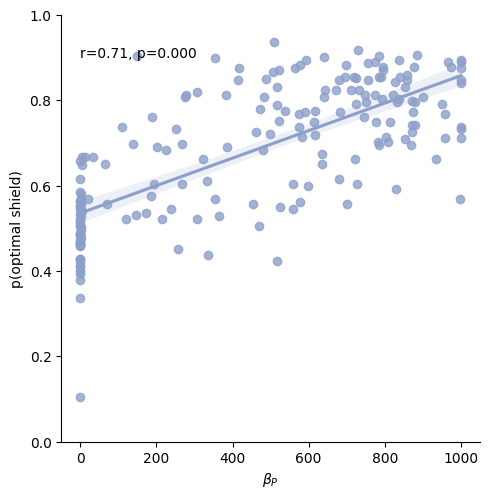

In [ ]:
# remove the cutoff
# change color of lmplot
colors = sns.color_palette("Set2")

sns.set_palette([colors[2]])
sns.lmplot(x='beta_ff', y='opti_ff', data=param, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(param.beta_ff, param.opti_ff)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{P}$')
plt.ylabel('p(optimal shield)') 

In [ ]:
# count proportion of beta_ss at bounds
param[(param.beta_ff<1) | (param.beta_ff>990000)].shape[0] / param.shape[0]


In [ ]:
# t-test in fullpilot12 for group value between beta_p and beta_v
pg.ttest(x=dd[(dd.expName=='FullPilot12') & (dd.group=='value') & (dd.model=='log-ratio') & (dd.param=='$\\beta_P$')].value,
         y=dd[(dd.expName=='FullPilot12') & (dd.group=='value') & (dd.model=='log-ratio') & (dd.param=='$\\beta_V$')].value)

In [ ]:
df['opti_ev'] = ((df.choice==1) & (df.ev1 > df.ev2)) | ((df.choice==2) & (df.ev2 > df.ev1))

In [ ]:
sns.set({'figure.figsize': (10, 14.5), 'figure.dpi': 100})

sns.set_context('talk')
sns.set_style("ticks")
# change palette must be very different from set2
palette = sns.color_palette("Set2")
# only select the first 3 colors
palette = palette[1:3][::-1]
# palette = ['grey']
palette.append('#feabf2')
sns.set_palette(palette)

count_subplot = 0
model = 'independent'

# dd['expName'] = dd.expName.map({'FullPilot12': 'all or none', 'FullPilot13': 'partial rew.', 'FullPilot14': 'partial destroy'})
# dd = dd[dd.param2!='beta_ff']
# dd.loc[dd.param=='$\\beta_V$', 'param'] = '$\\beta$'

# melt to have a opti and value column, where opti = ff, ss, ev and value = value
df3 = df[df.expName.isin(['FullPilot14']) & (df.session==3)].groupby(['agent', 'group'], as_index=False).mean(numeric_only=True)
# df3 = df.melt(id_vars=['agent', 'group'], value_vars=['opti_ff', 'opti_ss', 'opti_ev'], var_name='opti', value_name='value')
# df3 = df3.groupby(['agent', 'group'], as_index=False).mean(numeric_only=True).reset_index()
df3 = pd.melt(df3,
                   id_vars=['agent', 'group'], value_vars=['opti_ff', 'opti_ss', 'opti_ev'], var_name='opti', value_name='value')

# df3 = df3.groupby(['agent', 'group', 'opti'], as_index=False).value.mean().reset_index()
palette = sns.color_palette("Set2")
palette = palette[0:3][::-1]
for expName in ['FullPilot14']:
    count_subplot += 1
    plt.subplot(3, 1, count_subplot)
    sns.set_style("ticks")
    sns.set_context('talk')
    sns.set_palette(palette)
    order = ['perceptual', 'value', 'combined', 'random']
    sns.barplot(data=df3, x='group', y='value', hue='opti',  dodge=True, alpha=.8, errorbar='se', zorder=-1, order=order)
    sns.stripplot(data=df3, x='group', y='value', hue='opti', jitter=0.1,alpha=.8, dodge=True, edgecolor='black', linewidth=1, zorder=1, order=order)
    plt.ylim(-.05, 1.05)

    handles, labels = plt.gca().get_legend_handles_labels()
    # increase the size of the markers


    plt.legend(handles[3:], labels[3:], title='variable', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
    sns.despine(trim=True, bottom=True)
    plt.tick_params(axis='x', length=0)
    # hline
    plt.axhline(0.5, color='grey', linestyle='--')
    

    if expName=='FullPilot12':
        plt.title('all or none')
    if expName=='FullPilot13':
        plt.title('partial rew.')
    if expName=='FullPilot14':
        plt.title('partial destroy')

plt.tight_layout()

In [ ]:
df3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})
# set all fonts bigger
sns.set_context('talk')
sns.set_style('ticks')
# sns.set_style('dark')
# plt.style.use('dark_background')
# sns.set_palette('dark')
# sns.set_theme(style='dark')



def plot(y='value', hue='param', df=None):
    sns.violinplot(y=y, x='expName', hue=hue, zorder=-1, data=df, alpha=.6, linecolor='w', bw=0.5, gap=.1, split=True, 
                     inner_kws={'color': 'black', 'linewidth': 0.5}, palette=['C0', 'C1'], inner=None)
    ax=sns.pointplot(y=y, x='expName', hue=hue, zorder=2, data=df, dodge=True, ci=68, estimator=np.mean, markers='o', scale=1.3, color='black')
    m1 = df[df.param=='$\\beta_P$'].groupby('expName').mean(numeric_only=True).reset_index()
    m2 = df[df.param=='$\\beta_V$'].groupby('expName').mean(numeric_only=True).reset_index()
    # get x positon of the pointplot

    plt.scatter([-.025], m1.value, zorder=3, s=40, color='white')
    plt.scatter([.025], m2.value, zorder=3, s=40, color='white')
    ax = sns.stripplot(y=y, x='expName', hue=hue, zorder=1, size=10, 
                    data=df,dodge=True, edgecolor='white', linewidth=1, palette=['C0', 'C1'])
    # connect swarm dots with grey lines
    xlim = plt.xlim()
    # trace_lines_between_dots(df, y=y)
    # sns.lineplot(y=y, 
                #  x='expName', hue='pair2', zorder=2, style='pair2', 
                #    data=df_, alpha=1, color='grey', units='prolificID', estimator=None, legend=False
                #    )
    plt.xlim(xlim)
    trace_lines_between_dots(y=y, df=df)
    # plt.ylim(-.1, 1.1)
    # sns.pointplot(y=y, x='expName', hue='pair2', zorder=2, data=df_, dodge=True, ci=None, estimator=np.mean, markers='o', scale=1.5)
    
def get_x_from_y(y_value, ax, i):
    # Get the PathCollection (which contains the points' positions)
    collection = ax.collections[0]
    paths = collection.get_offsets()

    # Convert to a numpy array of points (x, y)
    points = np.array(paths)
    # Find the index of the closest point in terms of y value
    idx = (np.abs(points[:, 1] - y_value)).argmin()
    # Return the corresponding x value
    return points[idx, 0]      

# trace grey lines between hue categories swarm dots
# to do that we need to get the x position of each prolificID in the swarmplot
# and then draw a line between each pair of dots
def trace_lines_between_dots(y='opti_ss', ax=None, df=None):
    p1, p2 = df.param.unique()
    for j, expname in enumerate(np.sort(df.expName.unique())):
        for i, name in enumerate(df[df.expName==expname].agent.unique()):
            d1 = df[(df.agent==name) & (df.expName==expname) & (df.param==p1)]['value']
            assert len(d1) == 1
            d2 = df[(df.agent==name) & (df.expName==expname) & (df.param==p2)]['value']
            assert len(d2) == 1
            # d3 = df[(df.prolificID==name) & (df.expName==expname) & (df.y=='opti_ev')]['value']
            y2 = d2.values[0]
            y1 = d1.values[0]
            # y3 = d3.values[0]
            if ax:
                #this is the scatterplot ax
                # get the x position of the dot using y1, y2, y3
                # Function to find the x value corresponding to a given y value
                x1 = get_x_from_y(y1, ax, i)
                x2 = get_x_from_y(y2, ax, i)
                x3 = get_x_from_y(y3, ax, i)      
                plt.plot([x1, x2, x3], [y1, y2, y3], 'grey', alpha=.4)
                continue
                
            plt.plot([j-.15, j+.15], [y1, y2], 'grey', alpha=.4, zorder=-1)


# plt.subplot(1, 3, 1)
sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})

sns.set_context('talk')
sns.set_style('ticks')

#plt.plot([-0.5, len(df.session.unique())+.5], [0.5, 0.5], 'k--', alpha=0.5) 
# plt.plot([-0.5, 0.5], [0.5, 0.5], 'k--', alpha=0.5) 
dd = pd.read_csv('../data/processed/fit_params_fullpilot13.csv')
plot(y='value', df=dd)
plt.ylabel('Parameter strength')
sns.despine()
plt.xlabel('')
plt.xticks([])
#45 degree xticks
# plt.xticks(rotation=45)
# plt.legend([],[], frameon=False)
# only keep first two legend handles
handles = plt.gca().get_legend_handles_labels()[0]
# plt.legend(handles[0:3], ['spaceship', 'shield', 'optimal ev'], title='', loc='lower center', fontsize=12, title_fontsize=12)
# handle size
plt.xlabel('')

plt.tick_params(axis='x', length=0)
sns.despine(bottom=True)
# plt.xticks([0], ['session 1'])
param = dd.param.unique()
plt.legend(handles[:2][::-1], param[::-1], title='Parameter', bbox_to_anchor=(.01, -0.2), loc='lower left')
print(yticks)
plt.yticks(yticks)
# plt.legend().remove()

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(dd[dd.param=='$\\beta_P$'].value, dd[dd.param=='$\\beta_V$'].value)

In [ ]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
ddd = []
norm = lambda x: (x - x.min()) / (x.max() - x.min())
for agent, value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    delta = value[0] - value[1]
    ddd.append({
        'agent': agent,
        'expName': df[df.prolificID==agent].expName.values[0],
        # 'model': 'NormativeEV',
        'opti_ff': value[0],
        'opti_ss': value[1],
    })
    
ddd = pd.DataFrame(ddd)

ddd['opti_ff'] = norm(ddd.opti_ff)
ddd['opti_ss'] = norm(ddd.opti_ss)
ddd['delta'] = ddd.opti_ff - ddd.opti_ss

# ddd['group'] = ddd.apply(lambda x:'perceptual' if x.delta > 0.1 else 'value' if x.delta < -0.1 else 'combined', axis=1)
ddd['group'] = None
ddd.to_csv('../data/processed/fitting_FullPilot12.csv', index=False)


In [ ]:
group_df = pd.read_csv('../data/processed/df_fullpilot12.csv')

# set group from group_df to ddd using prolificID and agent columns
ddd['group'] = ddd.apply(lambda x: group_df[group_df.prolificID==x.agent].group.values[0], axis=1)

In [ ]:
# same but with scatterplot
sns.set(rc={'figure.figsize':(5,4)})
sns.set_context("talk")
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Function to create hand-drawn-like regions
def draw_handdrawn_region(center, hue, ax, radius=0.09, irregularity=0.004):
    # Generate random points around the center
    center = (center[0].mean(), center[1].mean())

    angles = np.linspace(0, 2 * np.pi, 20)
    # make it elliptical
    radius_x = radius - (radius/2)
    radius_y = radius + (radius/2)
    x_offsets = radius_x * np.cos(angles) + np.random.randn(20) * irregularity
    y_offsets = radius_y * np.sin(angles) + np.random.randn(20) * irregularity
    region_x = center[0] + x_offsets
    region_y = center[1] + y_offsets
    
    # clip the region to the axes boundaries in order to get oval shapes instead of circles
    # use max to cut off like 30% of the region

    # Fill the hand-drawn region with alpha
    ax.fill(region_x, region_y, color=hue, alpha=0.2, linewidth=0, zorder=2)

def draw_contour_region(center, hue, ax, radius=0.07):
    # Create a grid of points around the center
    x = np.linspace(center[0] - radius, center[0] + radius, 100)
    y = np.linspace(center[1] - radius, center[1] + radius, 100)
    X, Y = np.meshgrid(x, y)
    
    # Create a multivariate normal distribution for contour
    pos = np.dstack((X, Y))
    rv = multivariate_normal([center[0], center[1]], [[radius, 0], [0, radius]])
    Z = rv.pdf(pos)
    
    # Plot contourf for filled contours
    ax.contourf(X, Y, Z, levels=2, colors=hue, alpha=0.2)


df_ = ddd

# sort by group 
order = ['perceptual', 'combined', 'value', 'random']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
scatter = sns.scatterplot(data=df_, x='opti_ss', y='opti_ff', hue='group', palette=['C0', 'C2', 'C1', 'C7'], s=100)

# hightlight the clusters
# plt.axvline(0.5, color='gray', linestyle='--', alpha=0.2)
# plt.axhline(0.5, color='gray', linestyle='--', alpha=0.2)

# hightlight the clusters
# using seaborn, we want a region of interest using the colors of the clusters in scatterplot
sns.kdeplot(data=df_, x='opti_ss', y='opti_ff', alpha=0.2, fill=True, palette=['C0', 'C2', 'C1', 'C7'], hue='group', levels=2, bw_adjust=0.6, thresh=0.001) 
# Draw kdeplot for clusters with sufficient points

# change legend labels to add N=xx
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'{label} ({len(df_[df_.group==label])})' for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1)
           , loc=2, borderaxespad=0.)
data = df_
data['hue'] = data['group']
data['x'] = data['opti_ss']
data['y'] = data['opti_ff']
for hue_value in data['hue'].unique():
    
    subset = data[data['hue'] == hue_value]
    # For small groups, draw manual circles
    if len(subset) <= 2:
             # For small groups, draw hand-drawn regions
        draw_handdrawn_region((subset['x'], subset['y']), 'C2', plt.gca())
            


# add a third dimension (opti_ev)
# plt.ylim(0.3, 1)
# plt.xlim(0.3, 1)
plt.xlabel('p(optimal spaceship)')
plt.ylabel('p(optimal shield)')
# put legend outside
N = len(data)
# plt.title(f'counterfactual+R/2; N={N}')

#no legend
# plt.legend().remove()

In [ ]:
import matplotlib.pyplot as plt
# plot group distribution
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks")
sns.set_context('talk')
# create new df with count of participants in each group
df_ = ddd.groupby(['group']).size().reset_index(name='count')
order = ['perceptual', 'value', 'combined']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
# sort by count
df_ = df_.sort_values('count', ascending=False)
sns.barplot(data=df_, x='group', y='count', palette=['C0', 'C1', 'C2'])
plt.xticks(rotation=45)
plt.ylabel('Number of participants')

# annotate with count of participants
# order is 1=perceptual, 2=balanced, 3=value
for i, row in df_.iterrows():
    order_idx = order.index(row['group'])
    # plt.text(order_idx, row['count'], row['count'], ha='center')
    # annotate with count of participants
    # for each hue, so 6 annotations, 2 for each hue
    plt.text(order_idx, row['count'], row['count'], ha='center', va='bottom')
    # the above is centered, we want to offset to left and right according to hue, so 
    # if i % 2 == 0, then offset to the left, else offset to the right
    # offset = -0.2 if i % 2 == 0 else 0.2
    # plt.text(order_idx + offset, row['count'], row['count'], ha='center', va='bottom')

sns.despine(trim=True)

In [ ]:
# print likelihood function
# -----------------------------------------------------------------
# parameters to tune
import itertools
from pybads import BADS
import scipy.optimize as opt
from tqdm.notebook import tqdm
# timeit

pbar = tqdm(total=len(df.agent.unique()))

#install IPyWidgets

# space = np.arange(0, 100, 5)
space = np.linspace(0, 20, 20)
space_all = np.array(list(itertools.product(space, repeat=2)))
# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

xopt = {}
for agent in df.agent.unique():
    df2 = df[df.agent==agent]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]

    # xopt, fopt, fn1 = minimize(
        # f=fit,
        # args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space)
    
    # ...
    def target(x):
        return fit_pwf(x, *(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    lower_bounds = np.array([-10, -10])
    upper_bounds = np.array([10, 10])
    plausible_lower_bounds = np.array([1.0, 1.0])
    plausible_upper_bounds = np.array([5., 5.])
    # Starting point
    x0 = np.array([0, 0]);        

    bads = BADS(
        target,
        x0=x0[:1],
        lower_bounds=lower_bounds[:1],
        upper_bounds=upper_bounds[:1],
        # plausible_lower_bounds=plausible_lower_bounds[:1],
        # plausible_upper_bounds=plausible_upper_bounds[:1],
        options={'display': 'off'}
    )
    
    # xopt[agent] = opt.minimize(target, x0[:1], bounds=[(-10, 10)]).x[0]

    optimize_result = bads.optimize()
    
    xopt[agent] = optimize_result.x[0]
    continue

    # d.append({
        # 'agent': agent,
        # 'model': 'NormativeEV',
        # 'param': 'temp',
        # 'value': xopt
    # })

    # for i in range(len(fn1)):
    #     d.append({
    #         'agent': agent,
    #         'model': 'NormativeEV',
    #         # 'original_model': df2.model.values[0],
    #         'fn': fn1[i],
    #         'space': space[i],
    #     }) 

    xopt, fopt, params, fn2 = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space_all)
    # # print(xopt)
    d.append({
        'agent': agent,
        'model': 'NormativeLogRatio',
        'param': 'rl_temp',
        'value': xopt[1],
        'params': params
    })
    
    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeLogRatio',
    #     'param': 'perceptual_temp',
    #     'value': xopt[0],
    #     'params': params
    # })
    # # print(res)
    """ for i in range(len(fn2)):
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            # 'original_model': df2.model.values[0],
            'fn': fn2[i],
          'param': 'rl_temp',
          'value': space_all[i][1]
        }) 
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            'fn': fn2[i],
            'param': 'perceptual_temp',
            'value': space_all[i][0]
        })
 """
    pbar.update()


d = pd.DataFrame(d)
pbar.refresh()


In [ ]:
# display function with slope = mean(xopt)
import matplotlib.pyplot as plt

logistic = lambda slope, x: 1/(1+np.exp(-slope*x))
x = np.linspace(-1, 1, 12).round(2)
slope = np.mean(list(xopt.values())).round(2)
# slope = xopt['5610c4ea7ffc8a0005811504']

sns.set({'figure.figsize': (3, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

ax = plt.gca()
for agent, value in xopt.items():
    ax.plot(x, logistic(value, x), alpha=.2, color='black', label='fitted sub')
ax.plot(x, logistic(slope, x), label=f'fitted avg slope={slope}', color='C0')
# plot true slope = 2
ax.plot(x, logistic(2, x), label='true slope=2', color='C1')
ax.set_xlabel('Forcefield values')
ax.set_ylabel('P(destroy)')
ax.set_title('pwf')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# keep only last three for legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='upper left', bbox_to_anchor=(1, 1))
# loc of legend outside plot
print(xopt)

In [ ]:
df[df.prolificID=='5c5ac2869d974300015d81fc'].correct.mean()

In [ ]:
import scipy.optimize as opt
# i have probabilities (y)
# i need to find the x values that correspond to these probabilities
# i.e. the x values that give me the y values through the logistic function
# and find the slope that minimizes the difference between the x values and the forcefield values

x = np.unique([df.ff1.values, df.ff2.values])
y = np.unique([df.p1.values, df.p2.values])

def f(slope, x, y):
    return np.sum(np.abs(logistic(slope, x) - y))
    
opt.minimize(f, 0, args=(x, y))


In [ ]:
sns.set({'figure.figsize': (1, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

sns.boxplot(x='param', y='value', data=d)
# sns.stripplot(x='param', y='value', data=d,alpha=.9, palette='Set2')

In [ ]:
#plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[d.model=='NormativeEV']
plt.figure(figsize=(10, 3), dpi=100)
sns.lineplot(x='space', y='fn', data=dd, n_boot=0)
plt.ylabel('log likelihood')
plt.xlabel('$\\beta$')
plt.xticks(space)

# plt.xticks(space)


In [ ]:
# plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[(d.model=='NormativeLogRatio') & (d.original_model!='random')]
plt.figure(figsize=(15, 5), dpi=300)
count = 0
for model in dd.original_model.unique():
    count += 1
    ddd = dd[dd.original_model==model].pivot(index='perceptual_temp', columns='rl_temp', values='fn')
    # change index and columns to int
    ddd.columns = ddd.columns.astype(int)
    ddd.index = ddd.index.astype(int)
    # xy = ddd.space.values
    # stack xy as a 2d array
    # xy = np.vstack(xy)
    # z = ddd.fn.values

    # plot heatmap
    plt.subplot(1, len(dd.original_model.unique()), count)
    # rs = len(space)
    
    plt.title(f'original_model={model}')
    ax = sns.heatmap(ddd,square=True, annot=True, annot_kws={"size": 4}, fmt='.1f', vmax=30, vmin=0)
    d_ = np.asarray(ddd)
    y,x = np.unravel_index(d_.argmin(), d_.shape)
    ax.add_patch(plt.Rectangle((x, y), 1, 1, fc='none', ec='skyblue', lw=5, clip_on=False))


space_all[np.argmin(ddd)]

In [ ]:
# manual fit
# -----------------------------------------------------------------
# parameters to tune
import itertools

pbar = tqdm(total=len(df.agent.unique()))
space = np.concatenate([np.linspace(0, 10, 10), np.linspace(10, 50, 5)]).flatten().round(1)
print(space)
space_all = np.array(list(itertools.product(space, repeat=2)))

# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=1, space=space)
    
    d.append({
            'agent': agent,
            'model': 'NormativeEV',
            'original_model': df2['model'].values[0],
            'll': fopt,
            'fitted_temp': float(xopt),
            'temp': df2['temp'].values[0],
    })

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=2, space=space_all)
    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)


In [ ]:
# parameter retrieval
import scipy.optimize as opt
# import fit


models = (NormativeLogRatio, )
pbar = tqdm(total=len(df.agent.unique()))
method = 'scipy'
ub = [100]
lb = [.001]
x0 = np.mean([ub, lb], axis=0).tolist()

import pyfmincon.opt
pyfmincon.opt.connect()
d = []


for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    # if method == 'matlab':
    #     x = pyfmincon.opt.fmincon(
    #             function='fit.fit',
    #             x0=x0,
    #             optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
    #             lb=lb,
    #             ub=ub,
    #             options={}
    #     )
    #     xopt = x[0]
    #     fopt = x[1]


    # if method == 'scipy':
    #     res = opt.minimize(
    #         fit,
    #         x0,
    #         args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
    #         bounds=[(0, 10)])
    #     # xopt, fopt = matlab.fmincon(
    #     xopt = res.x[0]
    #     fopt = res.fun

    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeEV',
    #     'original_model': df2['model'].values[0],
    #     'll': fopt,
    #     'fitted_temp': float(xopt),
    #     'temp': df2['temp'].values[0],
    # })

    if method == 'matlab':
        x = pyfmincon.opt.fmincon(
                function='fit.fit2',
                x0=x0 * 2,
                # optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
                optional_args=[ntrials, s],
                lb=lb * 2,
                ub=ub * 2,
                options={}
        )
        xopt = x[0]
        fopt = x[1]

    if method == 'scipy':
        res = opt.minimize(
            fit,
            x0 * 2,
            args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
            bounds=[(0, 30), (0, 30)], options=dict(ftol=1e-8))
        
        xopt = res.x
        fopt = res.fun

    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)
d.to_csv('data/fit.csv', index=False)

In [ ]:
# select 30 perceptual neglect
d = pd.read_csv('data/fit.csv')
np.random.seed(1)
n = 30
d1 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')].sample(n=n)
assert len(d1.agent.unique()) == n
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='value neglect')].sample(n=n)
assert len(d2.agent.unique()) == n
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='balanced')].sample(n=n)
assert len(d3.agent.unique()) == n
d4 = d[(d.model=='NormativeLogRatio') & (d.original_model=='random')].sample(n=n)
assert len(d3.agent.unique()) == n



models = [d1, d2, d3, d4]

# d_full = pd.DataFrame()
# d_full['parameter'] = ['perceptual_temp', ] * n
# d_full['value'] = d1.
d_full = pd.concat(models)
length = len(d_full)
dfull = pd.DataFrame()
dfull['parameter'] = ['$\\beta_P$', ] * length + ['$\\beta_V$', ] * length
dfull['value'] = d_full['fitted_perceptual_temp'].tolist() + d_full['fitted_rl_temp'].tolist()
dfull['model'] = d_full['original_model'].tolist() * 2

# remove outliers using stats zscore
from scipy import stats
dfull['z'] = np.abs(stats.zscore(dfull['value']))
# dfull = dfull[dfull.z < 3]


plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
# increase axes width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
# increase font size
plt.rcParams.update({'font.size': 15})
sns.set_palette('deep')
palette = ['C2', 'C0', 'C1', 'grey']
sns.set_palette(palette=palette)

dfull1 = dfull[dfull.model=='balanced']
plt.subplot(1, 3, 1)
sns.barplot(x='parameter', y='value', data=dfull1, zorder=0, color='C0', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull1,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C0')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('balanced')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

dfull2 = dfull[dfull.model=='value neglect']
plt.subplot(1, 3, 3)
sns.barplot(x='parameter', y='value', data=dfull2, zorder=0, color='C1', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull2,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C1')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('perceptual maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)


dfull3 = dfull[dfull.model=='perceptual neglect']
plt.subplot(1, 3, 2)
sns.barplot(x='parameter', y='value', data=dfull3, zorder=0, color='C2', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull3,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C2')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('value maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)



plt.tight_layout()	
# plt.tick_params(axis='x', labelsize=8.5)
x1 = d_full[d_full.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = d_full[d_full.original_model=='value neglect'].fitted_perceptual_temp

x2 = d_full[d_full.original_model=='perceptual neglect'].fitted_rl_temp
y2 = d_full[d_full.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
print(pg.ttest(x1, x2))
print(pg.ttest(y1, y2))

plt.savefig('figs/result2.svg')

return

plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


return
# add a column 
from scipy import stats
 
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_perceptual_temp']))
# dfull = dfull[dfull.z < 2]
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_rl_temp']))
# dfull = dfull[dfull.z < 2]

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.subplot(1, 2, 1)
sns.barplot(x='original_model', y='fitted_perceptual_temp', data=dfull, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_perceptual_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_P$')
plt.tick_params(axis='x', labelsize=8.5)


plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


x1 = dfull[dfull.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = dfull[dfull.original_model=='value neglect'].fitted_perceptual_temp

x2 = dfull[dfull.original_model=='perceptual neglect'].fitted_rl_temp
y2 = dfull[dfull.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
pg.ttest(x1, y1)


In [ ]:
dfull.fitted_perceptual_temp

In [ ]:
# compute BIC 
d.loc[d.model=='NormativeLogRatio', 'bic'] = -2*-d[d.model=='NormativeLogRatio'].ll + np.log(ntrials)*2
d.loc[d.model=='NormativeEV', 'bic'] = -2*-d[d.model=='NormativeEV'].ll + np.log(ntrials)*1

# compute AIC
d.loc[d.model=='NormativeLogRatio', 'aic'] = -2*-d[d.model=='NormativeLogRatio'].ll + 2*2
d.loc[d.model=='NormativeEV', 'aic'] = -2*-d[d.model=='NormativeEV'].ll + 2*1

# plot BIC 
plt.figure(figsize=(5, 4), dpi=500)
sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)

sns.stripplot(x='model', y='bic', hue='original_model', data=d, dodge=True, size=4, alpha=.8, zorder=1, linewidth=.5, edgecolor='k')
plt.xlabel('fitted model')

# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='original model', loc='upper right')
plt.xlabel('fitted model')
plt.title('Model competition')

# Remove the default legend
# plt.gca().get_legend().remove()



In [ ]:
# plot fitted temp as barplot
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model=='NormativeEV']
sns.barplot(x='original_model', y='fitted_temp', data=dd, alpha=.2, zorder=-1)
sns.stripplot(x='original_model', y='fitted_temp', data=dd, linewidth=.5, s=7,
               edgecolor='black', zorder=1, palette=['C0', 'C1'])
# plot true temp as a dot
# sns.scatterplot(x='original_model', y='temp', data=dd, color='k', s=100)
plt.ylabel('fitted temperature')
# plt.ylim(1e5, 1e7)
plt.title('NormativeEV fitted')




In [ ]:
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model == 'NormativeLogRatio']

# Create a new DataFrame with the desired structure
df_combined = pd.DataFrame({
    'original_model': list(dd['original_model']) * 2,
    'variable': ['fitted_rl_temp'] * len(dd) + ['fitted_perceptual_temp'] * len(dd),
    'value': list(dd['fitted_rl_temp']) + list(dd['fitted_perceptual_temp'])
})

# Create a barplot with the new DataFrame
sns.barplot(
    x='original_model', y='value', hue='variable', data=df_combined, alpha=0.2)

# Add stripplot for additional data
sns.stripplot(
    x='original_model', y='value', hue='variable', data=df_combined, linewidth=0.5, s=7, edgecolor='black', zorder=1, dodge=True)

plt.ylabel('Temperature')
plt.title('NormativeLogRatio fitted')

# Customize the legend (optional)
# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='temperature', loc='lower right')
plt.ylim([20, 100])



In [ ]:
# fitted rl temp and perceptual temp
plt.figure(figsize=(4.9, 3))
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')]
# sns.barplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.4)
# light grey color 
c = '#cccccc'
sns.pointplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], color=c)
sns.swarmplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.8, zorder=2000)
# plt.ylim([5, 15])
plt.ylabel('fitted temperature')
plt.xticks([0, 1], ['RL temperature', 'Perceptual temperature'])
plt.title('NormativeLogRatio fitted')
plt.ylim([0, 21])

In [ ]:
# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
max_ = 15
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeEV') & (d.original_model=='NormativeEV')]
sns.scatterplot(x='temp', y='fitted_temp', data=d2, s=130, alpha=.8)
# plot identity
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.title('NormativeEV fitted')
# return
# plot linear regression with scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['temp'], d2['fitted_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

from scipy.stats import pearsonr

r, p = pearsonr(d2['temp'].dropna(), d2['fitted_temp'].dropna())
plt.text(0, 15, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})

In [ ]:
#same for logratio
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='NormativeLogRatio')]
sns.scatterplot(x='perceptual_temp', y='fitted_perceptual_temp', data=d2, s=120, alpha=.8, label='perceptual_temp')
sns.scatterplot(x='rl_temp', y='fitted_rl_temp', data=d2, s=120, alpha=.8, label='rl temp')
# plot identity line by finding min and max + 1
max_ = max(d2['perceptual_temp'].max(), d2['fitted_perceptual_temp'].max()) + 1
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.legend()
plt.title('NormativeLogRatio fitted')
plt.xlabel('true temperature')
plt.ylabel('fitted temperature')
plt.ylim([0, 15])
plt.xlim([0, 15])
# put same yticls and xticks labels
plt.yticks(np.arange(0, 16, 5))
plt.xticks(np.arange(0, 16, 5))

# add linear regression, confidence interval and pearson r
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['perceptual_temp'], d2['fitted_perceptual_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

# same for rl temp
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['rl_temp'], d2['fitted_rl_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C1', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='orange')

# pearson r
from scipy.stats import pearsonr
r, p = pearsonr(d2['perceptual_temp'].dropna(), d2['fitted_perceptual_temp'].dropna())
plt.text(2, 9, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})


# plot identity
# plt.plot([0, 10], [0, 15], color='k', linestyle='--')

In [ ]:
# data frame to store the results
dfsim = []
# define progress bar
pbar = tqdm(total=nagents*len(models))

# model parameters
normative_param1 = dict(delta_prior=.2, slope_prior=true_slope, temp=10, x=ff_values, leak=0)
normative_param2 = dict(delta_prior=.2, slope_prior=true_slope, rl_temp=1e2, perceptual_temp=1e4, 
x=ff_values, leak=0)

hybrid_param = dict(perceptual_temp=1e6, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=np.mean(blocks))

params = (normative_param1, normative_param2, {})
models = (NormativeEV, NormativeLogRatio, RandomModel)

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
agent_id = 0
for agent in range(nagents):
    for model, param in zip(models, params):
        
        d = d[d.agent==agent]

        p_temp = d.fitted_perceptual_temp.values[0]
        rl_temp = d.fitted_rl_temp.values[0]
        temp = d.fitted_temp.values[0]

        param.update({'perceptual_temp': p_temp, 'rl_temp': rl_temp})
        param.update({'temp': temp})
        
        m = model(**param)

        df2 = df[df.agent==agent]
        s = df2.s.values
        ff1, ff2, ffp1, ffp2 = \
            df2.ff1.values, df2.ff2.values, df2.ffp1.values, df2.ffp2.values
        ntrials = df2.trial.max()

        for t in range(ntrials):
            
            # state = s = block index
            s = block_idx[t]

            # make choice
            a = m.make_choice(s, ff1[t], ff2[t])
            
            ffp_chosen = [ffp1[t], ffp2[t]][a]
            ffp_unchosen = [ffp1[t], ffp2[t]][1-a]

            ff_chosen = [ff1[t], ff2[t]][a]
            ff_unchosen = [ff1[t], ff2[t]][1-a]
            
            destroy = np.random.random() < ffp_chosen
            
            m.learn_perceptual(ff_chosen, destroy)

            r = 0
            
            if destroy:
                r = tnormrdn(blocks[s][a], std)
                m.learn_value(s, a, r)
                
            optimal_option = a==0
            optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
            optimal_ff = ffp_chosen >= ffp_unchosen

            cumulative_reward += r

            dfsim.append(
                {
                    'temp': param.get('temp'),
                    'perceptual_temp': param.get('perceptual_temp'),
                    'rl_temp': param.get('rl_temp'),
                    'ff1': ff1[t],
                    'ff2': ff2[t],
                    'ffp1': ffp1[t],
                    'ffp2': ffp2[t],
                    'trial': t,
                    'model': str(model.__name__),
                    'agent': agent_id,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal_option': optimal_option,
                    'optimal_ev': optimal_ev,
                    'optimal_ff': optimal_ff,
                    'choice': ff[a],
                    'params': m.get_params(s=s),
                    'destroy': destroy,
                    'cumulative_reward': cumulative_reward
                }
            )
            
        pbar.update()

dfsim = pd.DataFrame(dfsim)
# unpack parameters
# tqdm.pandas()

# refresh progress bar
pbar.refresh()
print('done')

In [ ]:
# example of using scipy.optimize.minimize
import numpy as np
from scipy.optimize import minimize

def rosen(x, *args):
    """The Rosenbrock function"""
    print(args)
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
args = (1, 2, 3, 4)
res = minimize(rosen, x0, args=args, method='BFGS', options={'disp': True})

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['optimal_option'], avg['optimal_ff'], avg['optimal_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['optimal_option'])
    + ['forcefield',] * len(avg['optimal_ff'])
    + ['forcefield * option',] * len(avg['optimal_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

# replace barplot by distplot with dots
ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(optimal)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield * option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
# plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')

last_trial = df[df['trial'] == df['trial'].max()]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'LogitRLEV']['cumulative_reward'], df[df['model'] == 'NormativeEV']['cumulative_reward'])



In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


In [ ]:
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')

if 'params' in df.columns:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# plot evolution of parameters for each model
plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeEV'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine(trim=True)

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
sns.despine(trim=True)
plt.figure()
sns.lineplot(x='trial', y='σ', data=df[df.model=='NormativeEV'], label='σ', n_boot=0, errorbar='se')
# plot true delta (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[blocks[0][0] - blocks[0][1]] * 2, ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[blocks[1][0] - blocks[1][1]] * 2, ls='--', color='g', label='true σ (block 2)')
sns.despine(trim=True)